In [5]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import os
import pickle as pkl
from os.path import join as oj
from io import StringIO
from IPython.display import Image

import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import numpy as np
import pandas as pd
from sklearn import metrics, svm
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix, roc_curve
from sklearn.tree import DecisionTreeClassifier, plot_tree, export_graphviz, _tree
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from logitboost import LogitBoost
# from autogluon.tabular import TabularDataset, TabularPredictor

import imodels
import sys
sys.path.append('../../../../')
from rulevetting.api import validation
from rulevetting.projects.tbi_pecarn.dataset import Dataset
from rulevetting.projects.tbi_pecarn.graph import barplot
from rulevetting.projects.tbi_pecarn.baseline import Baseline


MODELS_DIR = './models'
os.makedirs(MODELS_DIR, exist_ok=True)

outcome_def = 'outcome'  # output
data_path = '../../../../data/' # path to raw csv - change to processed...

# default plotting properties - has to be an easier way then doing this every notebook
TINY_SIZE = 10
SMALL_SIZE = 12
MEDIUM_SIZE = 14
BIGGER_SIZE = 16
MARKER_SIZE = 6
LINE_SIZE = 4

plt.rc("font", size=SMALL_SIZE)  # controls default text sizes
plt.rc("axes", titlesize=BIGGER_SIZE)  # fontsize of the axes title
plt.rc("axes", labelsize=MEDIUM_SIZE)  # fontsize of the x and y labels
plt.rc("xtick", labelsize=SMALL_SIZE)  # fontsize of the tick labels
plt.rc("ytick", labelsize=SMALL_SIZE)  # fontsize of the tick labels
plt.rc("legend", fontsize=TINY_SIZE)  # legend fontsize
plt.rc("figure", titlesize=BIGGER_SIZE)  # fontsize of the figure title
plt.rc("lines", markersize=MARKER_SIZE)  # marker size
plt.rc("lines", linewidth=LINE_SIZE)  # line width

mpl.rcParams["figure.dpi"] = 180

# Height and width per row and column of subplots
FIG_HEIGHT = 20
FIG_WIDTH = 18
fig_fcn = lambda kwargs: plt.figure(figsize=(FIG_WIDTH, FIG_HEIGHT), **kwargs)
color_list = sns.color_palette("colorblind")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Training/Validating Several Models

In [6]:
from rulevetting.projects.tbi_pecarn.eval_models import *

def train_models (model_type, simple = False, which_age = 'all', hyper_dict = {}, title_str = None) :
    '''
    model_type  : One of ['Logistic Regression', 'Group Lasso', AdaBoost', 'LogitBoost', 'Decision Tree', 'SVM', 'RF'] - Which model to train
    which_age   : One of ['all', 'young', 'old']
    hyper_dict  : Dictionary containing hyperparameter values to tune (See Examples below)
    title_str   : Title for ROC curve (Default : "ROC curve of [MODEL_TYPE]")
    '''
    
    if model_type not in ['Logistic Regression', 'Group Lasso', 'AdaBoost', 'LogitBoost', 'Decision Tree', 'SVM', 'RF'] :
        print("ERROR: model_type should be one of ['Logistic Regression', 'Group Lasso',  'AdaBoost', 'LogitBoost', 'DecTree', 'SVM', 'RF']'")
        return
    
    # Dataset to use
    simple = simple    # 43 Columns or 120 Columns
    young = True
    old = True
    
    if which_age == 'young' :  #(6432 + 2144 + 2145 samples)
        old = False
    elif which_age == 'old' :  #(19025 + 6342 + 6432 samples)
        young = False

    df_train, df_tune, df_test = Dataset().get_data(simple = simple, young = young, old = old)
    outcome_def = 'outcome'
    
    X_train = df_train.drop(columns = outcome_def)
    y_train = df_train[outcome_def].values
    X_tune = df_tune.drop(columns = outcome_def)
    y_tune = df_tune[outcome_def].values

    
    # title_str
    ts = "ROC curve of " + model_type if title_str is None else title_str
    
    if model_type == 'Logistic Regression' :
        lv= hyper_dict['lamb_vec'] if 'lamb_vec' in hyper_dict.keys() else np.logspace(-1, 4, 20)
        return fit_eval_lr(X_train, y_train, X_tune, y_tune, ts, lamb_vec = lv)
    elif model_type == 'Group Lasso' :
        lv= hyper_dict['lamb_vec'] if 'lamb_vec' in hyper_dict.keys() else np.logspace(-4, -2.5, 10)
        return fit_eval_grouplr(X_train, y_train, X_tune, y_tune, ts, lamb_vec = lv)
    elif model_type == 'AdaBoost' :
        ne = hyper_dict['n_estimator'] if 'n_estimator' in hyper_dict.keys() else 100
        return fit_eval_boosted(X_train, y_train, X_tune, y_tune, ts, which_boost = 'AdaBoost', n_estimator = ne)
    elif model_type == 'LogitBoost' :    
        ne = hyper_dict['n_estimator'] if 'n_estimator' in hyper_dict.keys() else 100
        return fit_eval_boosted(X_train, y_train, X_tune, y_tune, ts, which_boost = 'LogitBoost', n_estimator = ne)
    elif model_type == 'Decision Tree' :
        de = hyper_dict['depth'] if 'depth' in hyper_dict.keys() else list(range(1, 6))
        wr = hyper_dict['weight_ratio'] if 'weight_ratio' in hyper_dict.keys() else [1, 100]
        return fit_eval_decTree(X_train, y_train, X_tune, y_tune, ts, depth = de , weight_ratio = wr)
    elif model_type == 'SVM' :
        # hynsuk's old gamma vals: [2**(-2), 2**(-1.5), 2**(-1), 2**(-0.5), 1, 2**(1)]
        gv = hyper_dict['gamma_vec'] if 'gamma_vec' in hyper_dict.keys() else [2**(-5), 2**(-4), 2**(-3), 2**(-2), 2**(2), 2**(4)]
        return fit_eval_svm(X_train, y_train, X_tune, y_tune, ts, gamma_vec = gv)
    elif model_type == 'RF' :
        return fit_eval_rf(X_train, y_train, X_tune, y_tune, ts)             
                            


In [3]:
# Examples of using train_models funciton
'''
model_type  : One of ['Logistic Regression', 'AdaBoost', 'LogitBoost', 'DecTree', 'SVM', 'RF'] - Which model to train
which_age   : One of ['all', 'young', 'old']
hyper_dict  : Dictionary containing hyperparameter values to tune (See Examples below)
              
              Logistic Regression   - lamb_vec    : list of lambdas
              AdaBoost / LogitBoost - n_estimator : the number of weak learners
              Decision Tree         - depth       : max_depth of trees
                                    - weight_ratio: list of class weight ratio (non-tbi : 1, tbi : given weight)
              SVM                   - gamma_vec   : list of gammas
              
title_str   : Title for ROC curve (Default : "ROC curve of [MODEL_TYPE]")
'''
    
# Logistic Regression
#train_models (model_type = 'Logistic Regression', title_str = None, simple = False, 
#              which_age = 'all', hyper_dict = {'lambda_vec' : [0.5, 1, 1.5]})

# AdaBoost
#train_models (model_type = 'AdaBoost', title_str = None, simple = False, 
#              which_age = 'all', hyper_dict = {'n_estimator' : 100})

# LogitBoost
#with warnings.catch_warnings():
#    warnings.simplefilter("ignore")
#    train_models (model_type = 'LogitBoost', title_str = None, simple = False, 
#              which_age = 'all', hyper_dict = {'n_estimator' : 100})

# Decision Tree
#train_models (model_type = 'Decision Tree', title_str = None, simple = False, 
#              which_age = 'all', hyper_dict = {'depth' : list(range(1, 6)), 'weight_ratio' : [1, 100]})

# SVM
#train_models (model_type = 'SVM', title_str = None, simple = False, 
#              which_age = 'all', hyper_dict = {'gamma_vec' : [0.5, 1]})

# RF
#train_models (model_type = 'RF', title_str = None, simple = False, which_age = 'all')





'\nmodel_type  : One of [\'Logistic Regression\', \'AdaBoost\', \'LogitBoost\', \'DecTree\', \'SVM\', \'RF\'] - Which model to train\nwhich_age   : One of [\'all\', \'young\', \'old\']\nhyper_dict  : Dictionary containing hyperparameter values to tune (See Examples below)\n              \n              Logistic Regression   - lamb_vec    : list of lambdas\n              AdaBoost / LogitBoost - n_estimator : the number of weak learners\n              Decision Tree         - depth       : max_depth of trees\n                                    - weight_ratio: list of class weight ratio (non-tbi : 1, tbi : given weight)\n              SVM                   - gamma_vec   : list of gammas\n              \ntitle_str   : Title for ROC curve (Default : "ROC curve of [MODEL_TYPE]")\n'

In [7]:
# Load data

outcome_def = 'outcome'

df_train, df_tune, df_test = Dataset().get_data(simple = False, young = True, old = False)
X_train_young = df_train.drop(columns = outcome_def)
y_train_young = df_train[outcome_def].values
X_tune_young = df_tune.drop(columns = outcome_def)
y_tune_young = df_tune[outcome_def].values
X_test_young = df_test.drop(columns = outcome_def)
y_test_young = df_test[outcome_def].values

df_train, df_tune, df_test = Dataset().get_data(simple = False, young = False, old = True)
X_train_old = df_train.drop(columns = outcome_def)
y_train_old = df_train[outcome_def].values
X_tune_old = df_tune.drop(columns = outcome_def)
y_tune_old = df_tune[outcome_def].values
X_test_old = df_test.drop(columns = outcome_def)
y_test_old = df_test[outcome_def].values

df_train, df_tune, df_test = Dataset().get_data(simple = False, young = True, old = True)
X_train_all = df_train.drop(columns = outcome_def)
y_train_all = df_train[outcome_def].values
X_tune_all = df_tune.drop(columns = outcome_def)
y_tune_all = df_tune[outcome_def].values
X_test_all = df_test.drop(columns = outcome_def)
y_test_all = df_test[outcome_def].values

kwargs {'clean_data': {}, 'preprocess_data': {'infer_outcome': True, 'drop_low_gcs': True, 'impute_unknowns': 'mode', 'impute_not_applicables': True}, 'extract_features': {}}
kwargs {'clean_data': {}, 'preprocess_data': {'infer_outcome': True, 'drop_low_gcs': True, 'impute_unknowns': 'mode', 'impute_not_applicables': True}, 'extract_features': {}}
kwargs {'clean_data': {}, 'preprocess_data': {'infer_outcome': True, 'drop_low_gcs': True, 'impute_unknowns': 'mode', 'impute_not_applicables': True}, 'extract_features': {}}


In [5]:
np.sum(df_train['outcome']) + np.sum(df_tune['outcome']) + np.sum(df_test['outcome'])

376

## Training and validating models

kwargs {'clean_data': {}, 'preprocess_data': {'infer_outcome': True, 'drop_low_gcs': True, 'impute_unknowns': 'mode', 'impute_not_applicables': True}, 'extract_features': {}}


100%|████████████████████████████████████████| 445/445 [00:02<00:00, 202.94it/s]


Confusion Matrix : 
 [[  14    0]
 [ 507 1623]]
Prob. threshold : 0.00791
AUC             : 0.938
Accuracy        : 0.764
Sensitivity     : 1.000
Specificity     : 0.762
Balanced Acc.   : 0.881
NPV             : 1.000


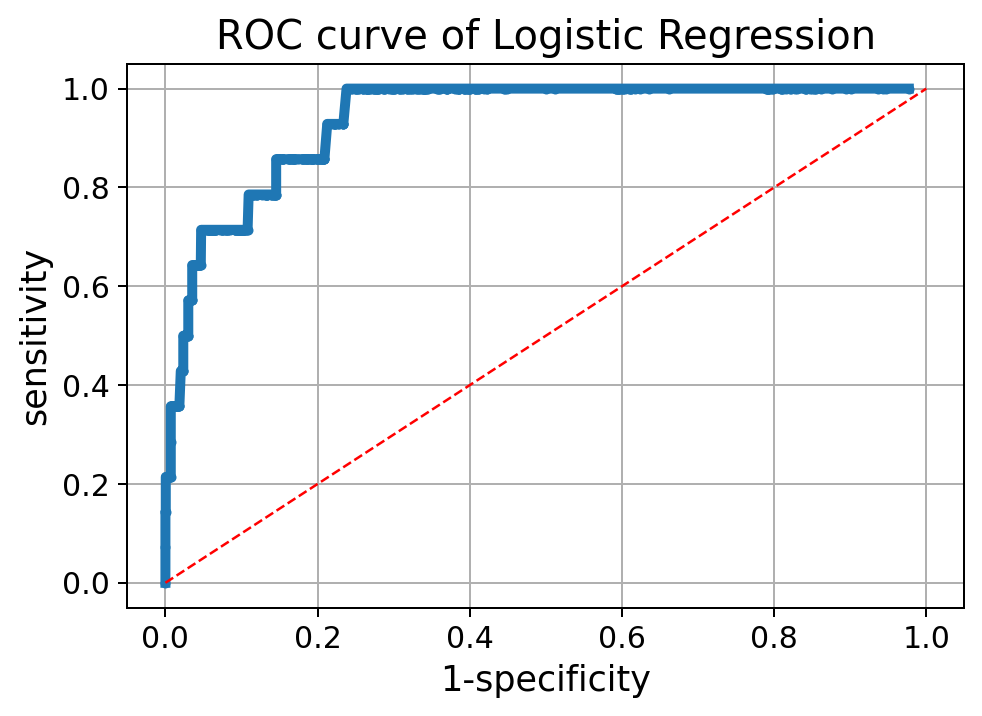

kwargs {'clean_data': {}, 'preprocess_data': {'infer_outcome': True, 'drop_low_gcs': True, 'impute_unknowns': 'mode', 'impute_not_applicables': True}, 'extract_features': {}}


100%|███████████████████████████████████████| 3502/3502 [00:49<00:00, 70.56it/s]


Confusion Matrix : 
 [[  45    2]
 [1574 4721]]
Prob. threshold : 0.00630
AUC             : 0.931
Accuracy        : 0.751
Sensitivity     : 0.957
Specificity     : 0.750
Balanced Acc.   : 0.854
NPV             : 1.000


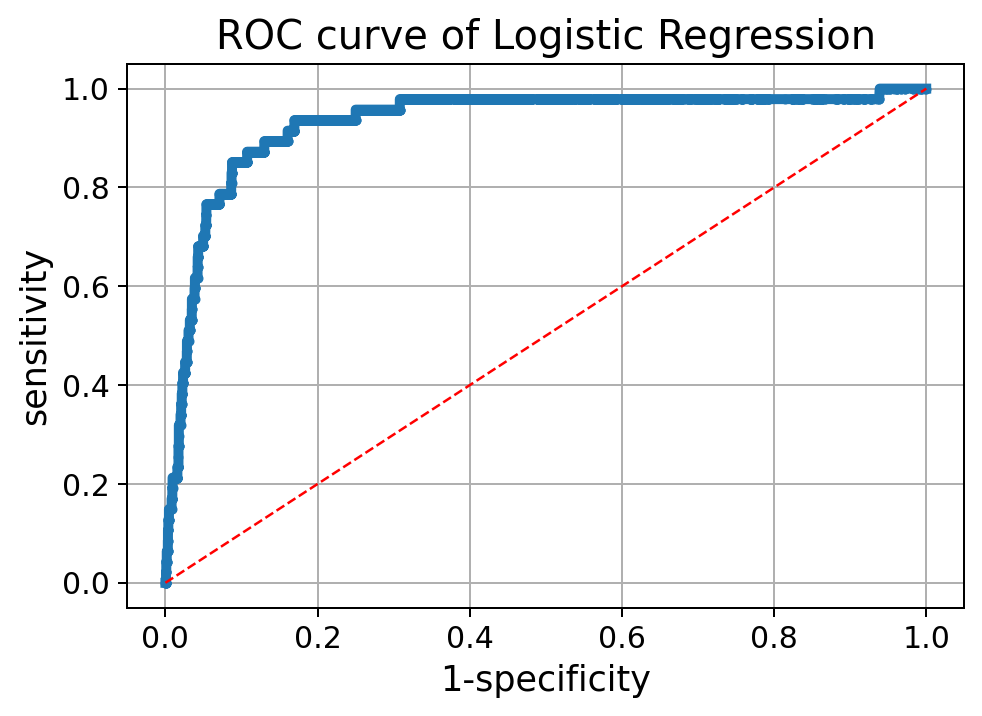

kwargs {'clean_data': {}, 'preprocess_data': {'infer_outcome': True, 'drop_low_gcs': True, 'impute_unknowns': 'mode', 'impute_not_applicables': True}, 'extract_features': {}}


100%|███████████████████████████████████████| 4973/4973 [01:33<00:00, 53.36it/s]


Confusion Matrix : 
 [[  80    4]
 [2114 6288]]
Prob. threshold : 0.00491
AUC             : 0.917
Accuracy        : 0.750
Sensitivity     : 0.952
Specificity     : 0.748
Balanced Acc.   : 0.850
NPV             : 0.999


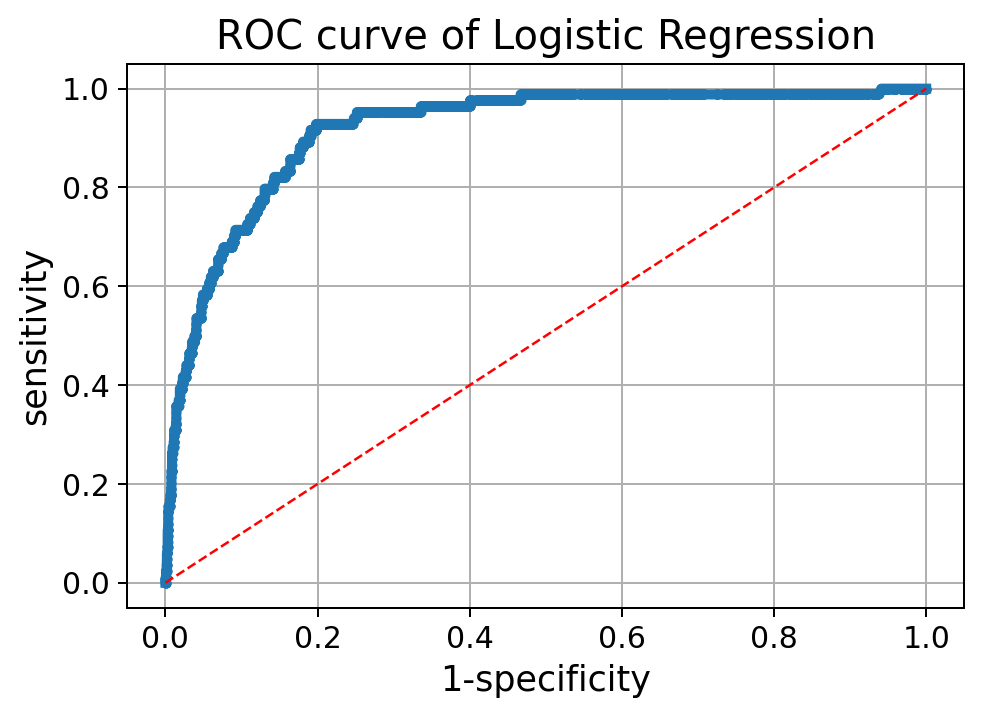

['./models/lr_model_all.joblib']

In [6]:
# Logistic Regression
lambda_list = np.logspace(-1, 4, 20)

lr_model_young, lr_stats_young = train_models (model_type = 'Logistic Regression', 
                                                title_str = None, simple = False, 
                                                which_age = 'young', 
                                              hyper_dict = {'lamb_vec' : lambda_list})
lr_model_old, lr_stats_old = train_models (model_type = 'Logistic Regression', 
                                                title_str = None, simple = False, 
                                                which_age = 'old', 
                                          hyper_dict = {'lamb_vec' : lambda_list})

lr_model_all, lr_stats_all = train_models (model_type = 'Logistic Regression', 
                                                title_str = None, simple = False, 
                                                which_age = 'all', 
                                          hyper_dict = {'lamb_vec' : lambda_list})

from joblib import dump, load
dump(lr_model_young, './models/lr_model_young.joblib') 
dump(lr_model_old, './models/lr_model_old.joblib') 
dump(lr_model_all, './models/lr_model_all.joblib') 

kwargs {'clean_data': {}, 'preprocess_data': {'infer_outcome': True, 'drop_low_gcs': True, 'impute_unknowns': 'mode', 'impute_not_applicables': True}, 'extract_features': {}}


100%|██████████████████████████████████████| 1084/1084 [00:06<00:00, 168.98it/s]


Confusion Matrix : 
 [[  14    0]
 [ 583 1547]]
Prob. threshold : 0.00370
AUC             : 0.908
Accuracy        : 0.728
Sensitivity     : 1.000
Specificity     : 0.726
Balanced Acc.   : 0.863
NPV             : 1.000
Coefficient for each variable is as following :
Seiz            : 1.39174
ActNorm         : -0.41938
Vomit           : -0.52090
Intubated       : 0.00000
Paralyzed       : 0.00000
Sedated         : 0.00000
AMS             : 1.35783
AMSAgitated     : 0.12392
AMSSleep        : -0.35499
AMSSlow         : 0.70217
AMSRepeat       : 0.00000
AMSOth          : 0.37894
FontBulg        : 0.00000
SFxBas          : 0.60721
SFxBasHem       : 1.48328
SFxBasOto       : -0.16227
SFxBasPer       : -0.43972
SFxBasRet       : -0.25514
SFxBasRhi       : -0.05024
Hema            : -0.42253
Clav            : 0.42302
ClavFace        : -0.27469
ClavNeck        : -1.11140
ClavFro         : 0.05892
ClavOcc         : 0.50186
ClavPar         : 0.51143
ClavTem         : -0.11110
NeuroD          : 1.0

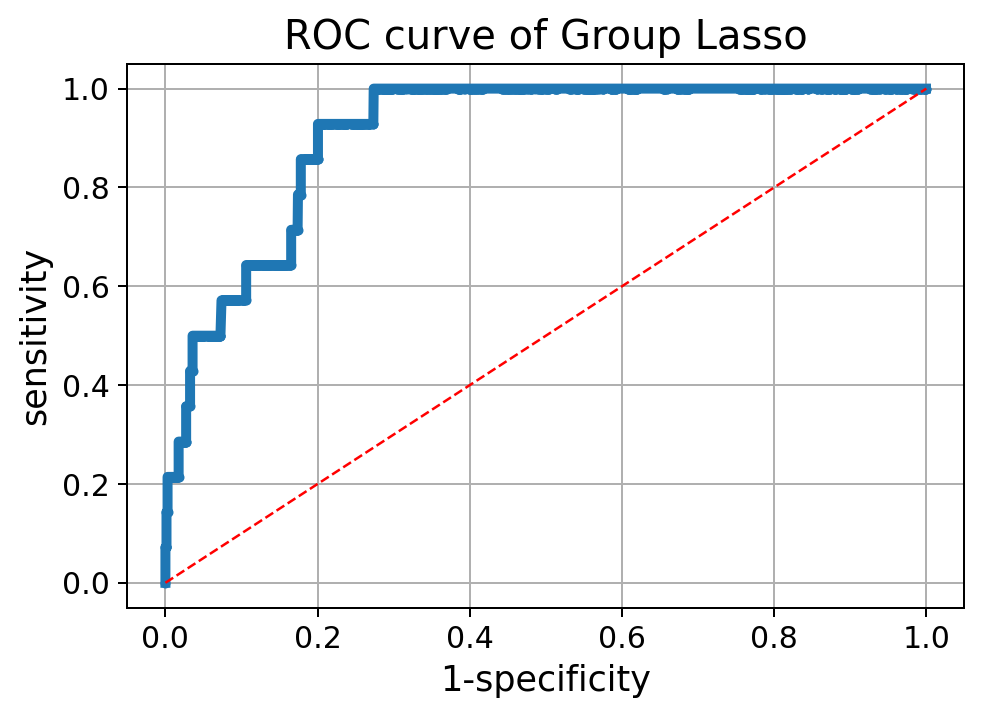

kwargs {'clean_data': {}, 'preprocess_data': {'infer_outcome': True, 'drop_low_gcs': True, 'impute_unknowns': 'mode', 'impute_not_applicables': True}, 'extract_features': {}}


100%|███████████████████████████████████████| 4203/4203 [00:59<00:00, 70.87it/s]


Confusion Matrix : 
 [[  45    2]
 [2028 4267]]
Prob. threshold : 0.00359
AUC             : 0.917
Accuracy        : 0.680
Sensitivity     : 0.957
Specificity     : 0.678
Balanced Acc.   : 0.818
NPV             : 1.000
Coefficient for each variable is as following :
Seiz            : -0.33188
ActNorm         : 0.33952
Vomit           : 0.72708
Intubated       : 0.00000
Paralyzed       : 0.00000
Sedated         : -0.54445
AMS             : 1.11616
AMSAgitated     : 0.97475
AMSSleep        : 0.22938
AMSSlow         : 0.41038
AMSRepeat       : 0.62420
AMSOth          : -0.27865
FontBulg        : 0.00000
SFxBas          : 1.21630
SFxBasHem       : 1.07980
SFxBasOto       : -0.12408
SFxBasPer       : -0.47741
SFxBasRet       : 0.44004
SFxBasRhi       : -0.10316
Hema            : 0.00000
Clav            : 0.60118
ClavFace        : -0.33250
ClavNeck        : 0.56401
ClavFro         : -0.13448
ClavOcc         : -0.10473
ClavPar         : 0.62726
ClavTem         : 0.16460
NeuroD          : 0.552

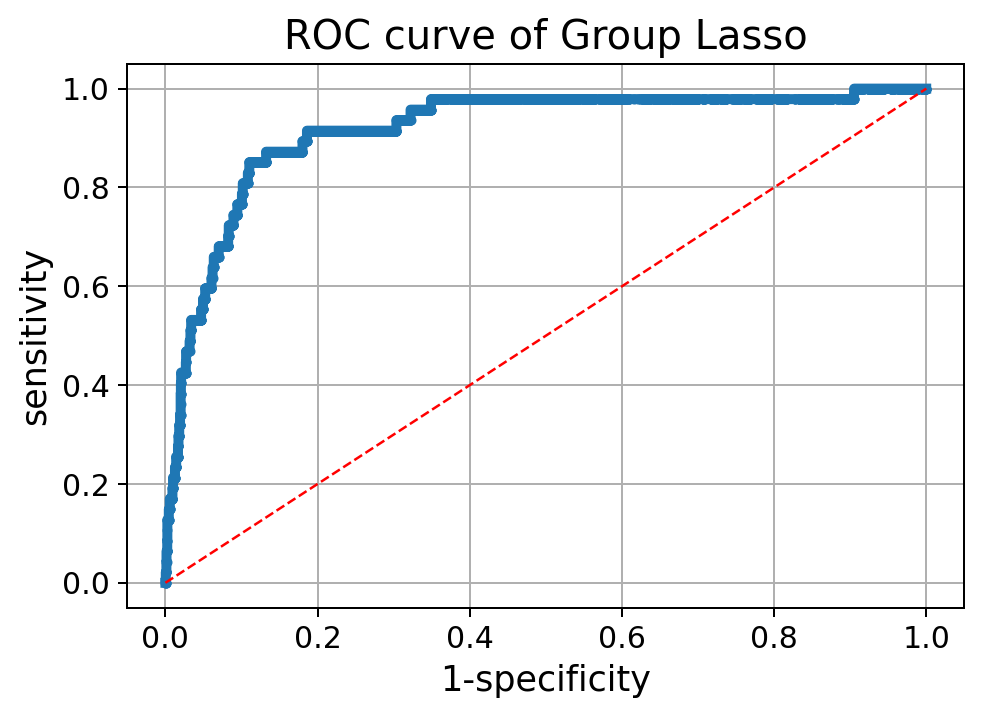

kwargs {'clean_data': {}, 'preprocess_data': {'infer_outcome': True, 'drop_low_gcs': True, 'impute_unknowns': 'mode', 'impute_not_applicables': True}, 'extract_features': {}}


100%|███████████████████████████████████████| 5199/5199 [01:36<00:00, 53.75it/s]


Confusion Matrix : 
 [[  80    4]
 [2160 6242]]
Prob. threshold : 0.00455
AUC             : 0.917
Accuracy        : 0.745
Sensitivity     : 0.952
Specificity     : 0.743
Balanced Acc.   : 0.848
NPV             : 0.999
Coefficient for each variable is as following :
Seiz            : 0.31366
ActNorm         : -0.18006
Vomit           : 0.44758
Intubated       : 0.00000
Paralyzed       : 0.00000
Sedated         : 0.00000
AMS             : 1.10772
AMSAgitated     : 0.79296
AMSSleep        : 0.36275
AMSSlow         : 0.58137
AMSRepeat       : 0.29128
AMSOth          : 0.18610
FontBulg        : 0.00000
SFxBas          : 1.35870
SFxBasHem       : 1.29969
SFxBasOto       : 0.56615
SFxBasPer       : -0.49214
SFxBasRet       : -0.26244
SFxBasRhi       : -0.21435
Hema            : 0.00000
Clav            : 0.32008
ClavFace        : 0.12114
ClavNeck        : 0.33874
ClavFro         : 0.34499
ClavOcc         : 0.49716
ClavPar         : 0.46683
ClavTem         : 0.14518
NeuroD          : 0.74461
Ne

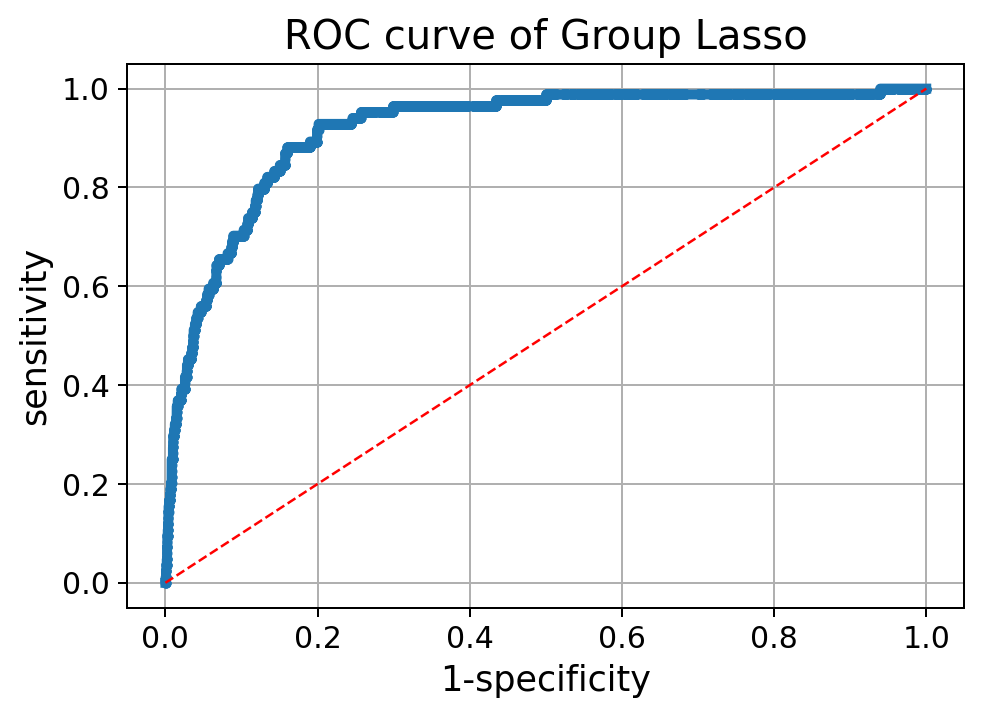

In [7]:
# Grouped Lasso LR

lamb_list2 = np.logspace(-4, -2.5, 10)

grlr_model_young, grlr_stats_young = train_models (model_type = 'Group Lasso', 
                                                title_str = None, simple = False, 
                                                which_age = 'young', hyper_dict = {'lamb_vec' : lamb_list2})

grlr_model_old, grlr_stats_old = train_models (model_type = 'Group Lasso', 
                                                title_str = None, simple = False, 
                                                which_age = 'old', hyper_dict = {'lamb_vec' : lamb_list2})

grlr_model_all, grlr_stats_all = train_models (model_type = 'Group Lasso', 
                                                title_str = None, simple = False, 
                                                which_age = 'all', hyper_dict = {'lamb_vec' : lamb_list2})


kwargs {'clean_data': {}, 'preprocess_data': {'infer_outcome': True, 'drop_low_gcs': True, 'impute_unknowns': 'mode', 'impute_not_applicables': True}, 'extract_features': {}}


100%|████████████████████████████████████████| 867/867 [00:04<00:00, 200.46it/s]


Confusion Matrix : 
 [[  14    0]
 [2006  124]]
Prob. threshold : 0.39990
AUC             : 0.781
Accuracy        : 0.064
Sensitivity     : 1.000
Specificity     : 0.058
Balanced Acc.   : 0.529
NPV             : 1.000


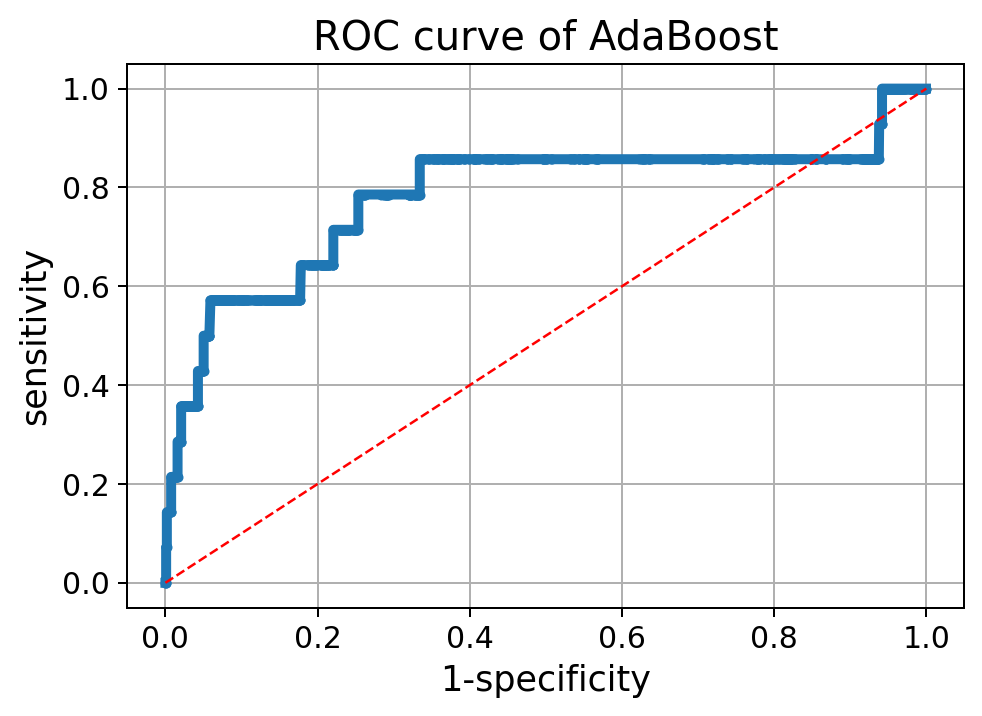

/Users/aprasad/Library/Python/3.9/lib/python/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


kwargs {'clean_data': {}, 'preprocess_data': {'infer_outcome': True, 'drop_low_gcs': True, 'impute_unknowns': 'mode', 'impute_not_applicables': True}, 'extract_features': {}}


100%|███████████████████████████████████████| 3698/3698 [00:52<00:00, 70.67it/s]


Confusion Matrix : 
 [[  45    2]
 [4755 1540]]
Prob. threshold : 0.48096
AUC             : 0.872
Accuracy        : 0.250
Sensitivity     : 0.957
Specificity     : 0.245
Balanced Acc.   : 0.601
NPV             : 0.999


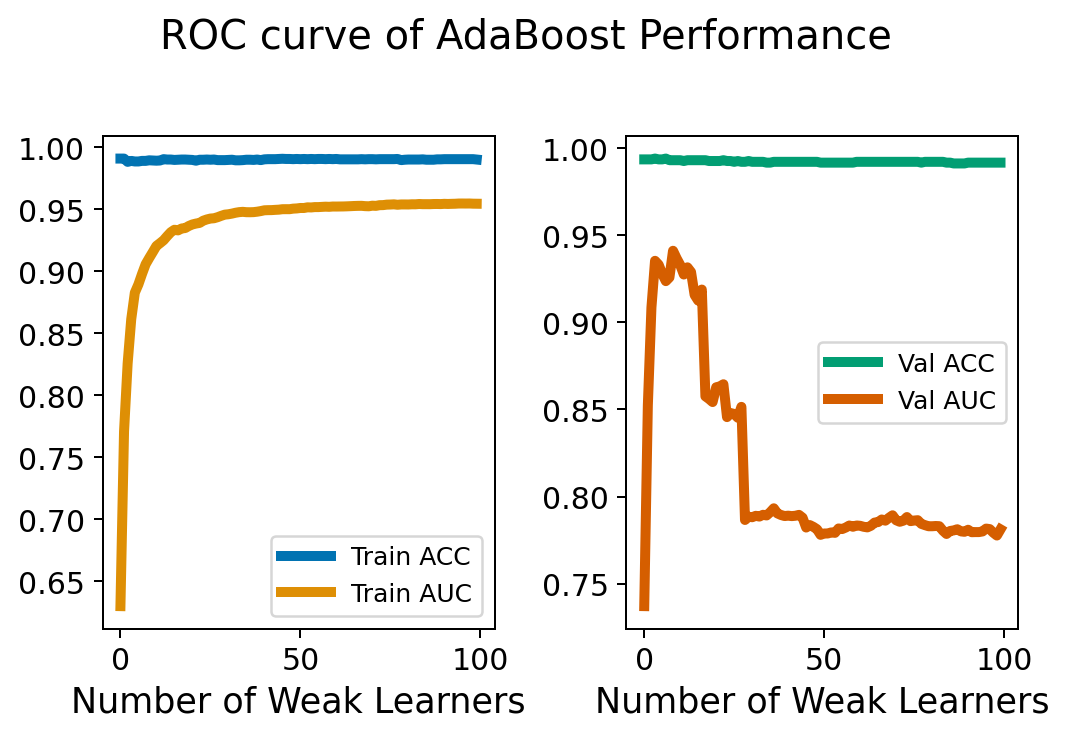

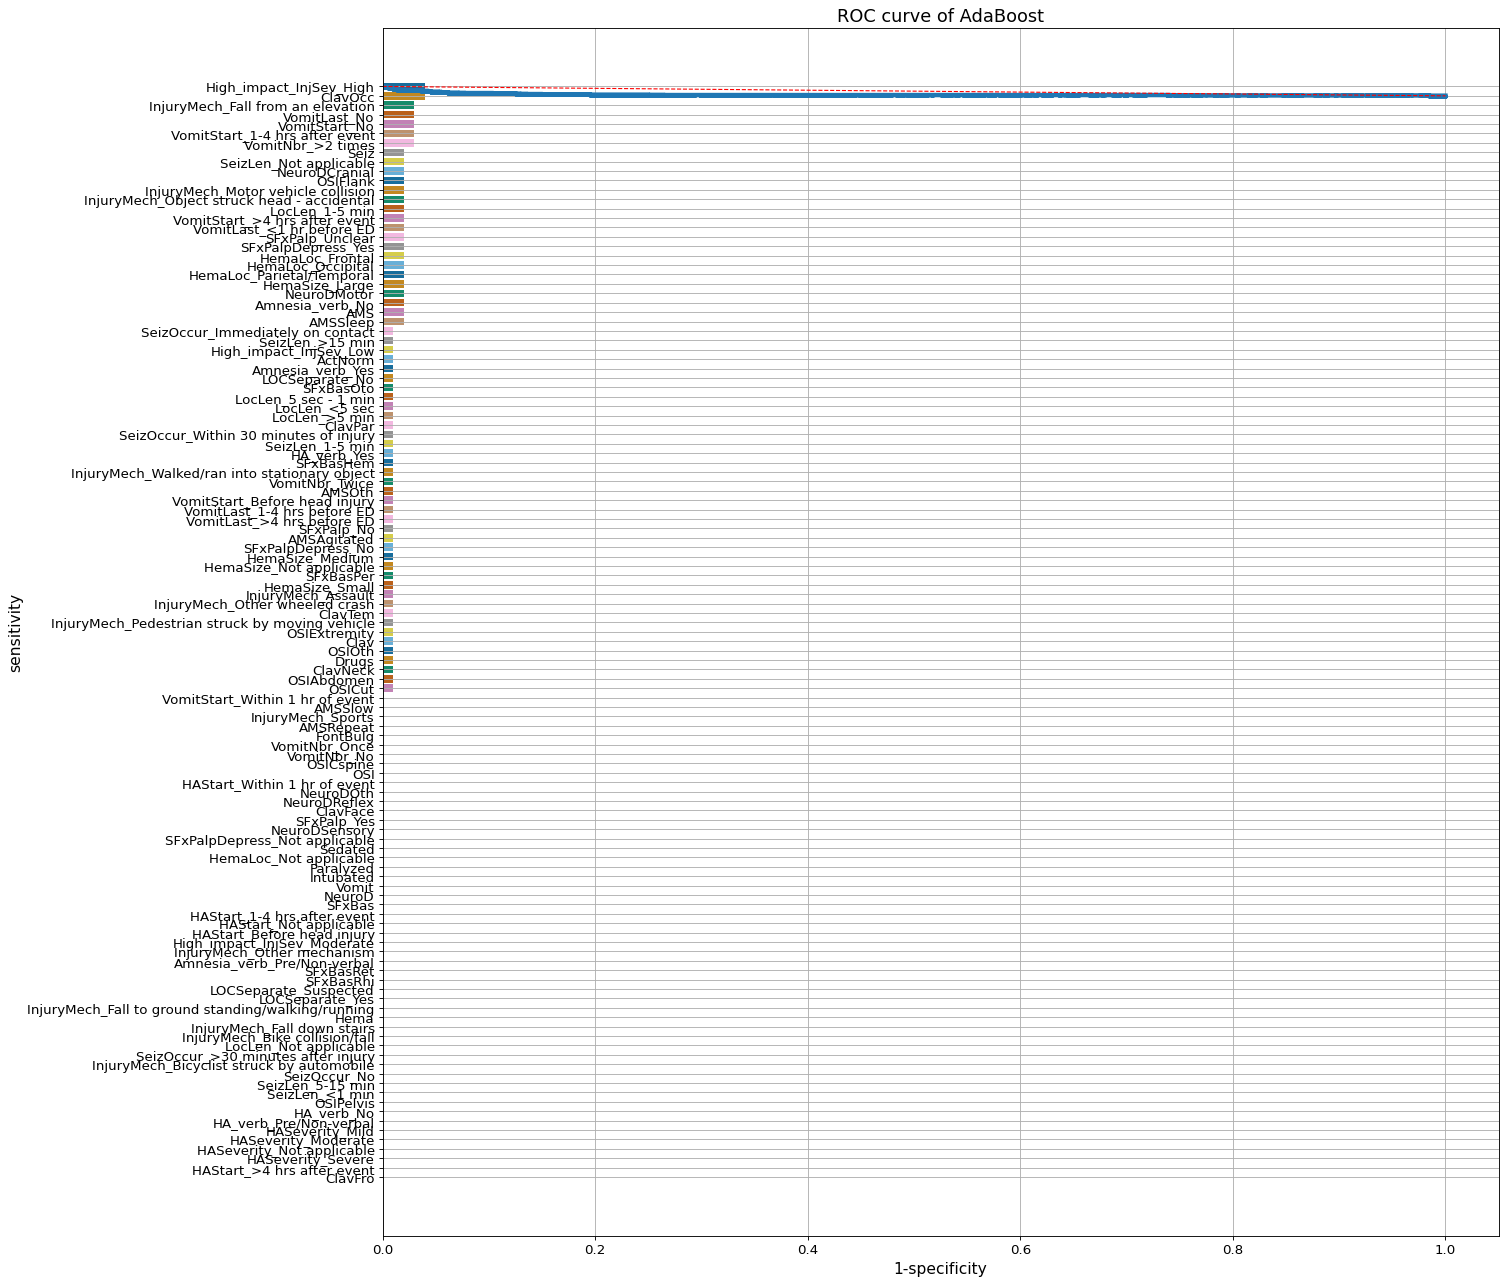

/Users/aprasad/Library/Python/3.9/lib/python/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


kwargs {'clean_data': {}, 'preprocess_data': {'infer_outcome': True, 'drop_low_gcs': True, 'impute_unknowns': 'mode', 'impute_not_applicables': True}, 'extract_features': {}}


100%|███████████████████████████████████████| 4547/4547 [01:23<00:00, 54.19it/s]


Confusion Matrix : 
 [[  80    4]
 [3472 4930]]
Prob. threshold : 0.48336
AUC             : 0.899
Accuracy        : 0.590
Sensitivity     : 0.952
Specificity     : 0.587
Balanced Acc.   : 0.770
NPV             : 0.999


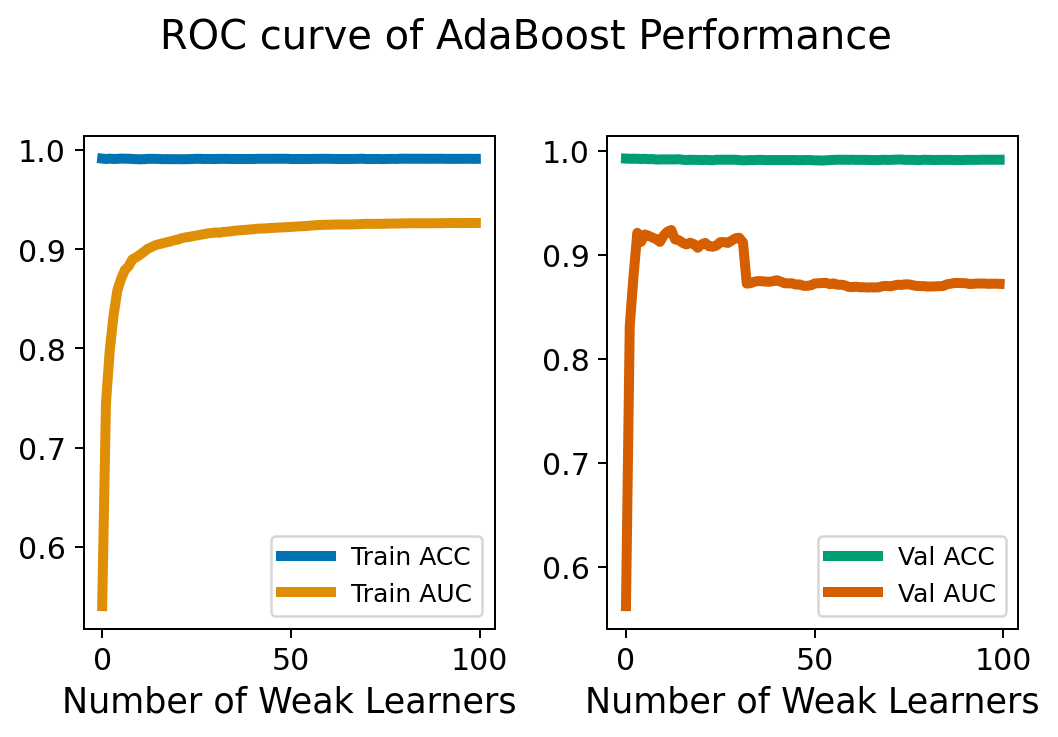

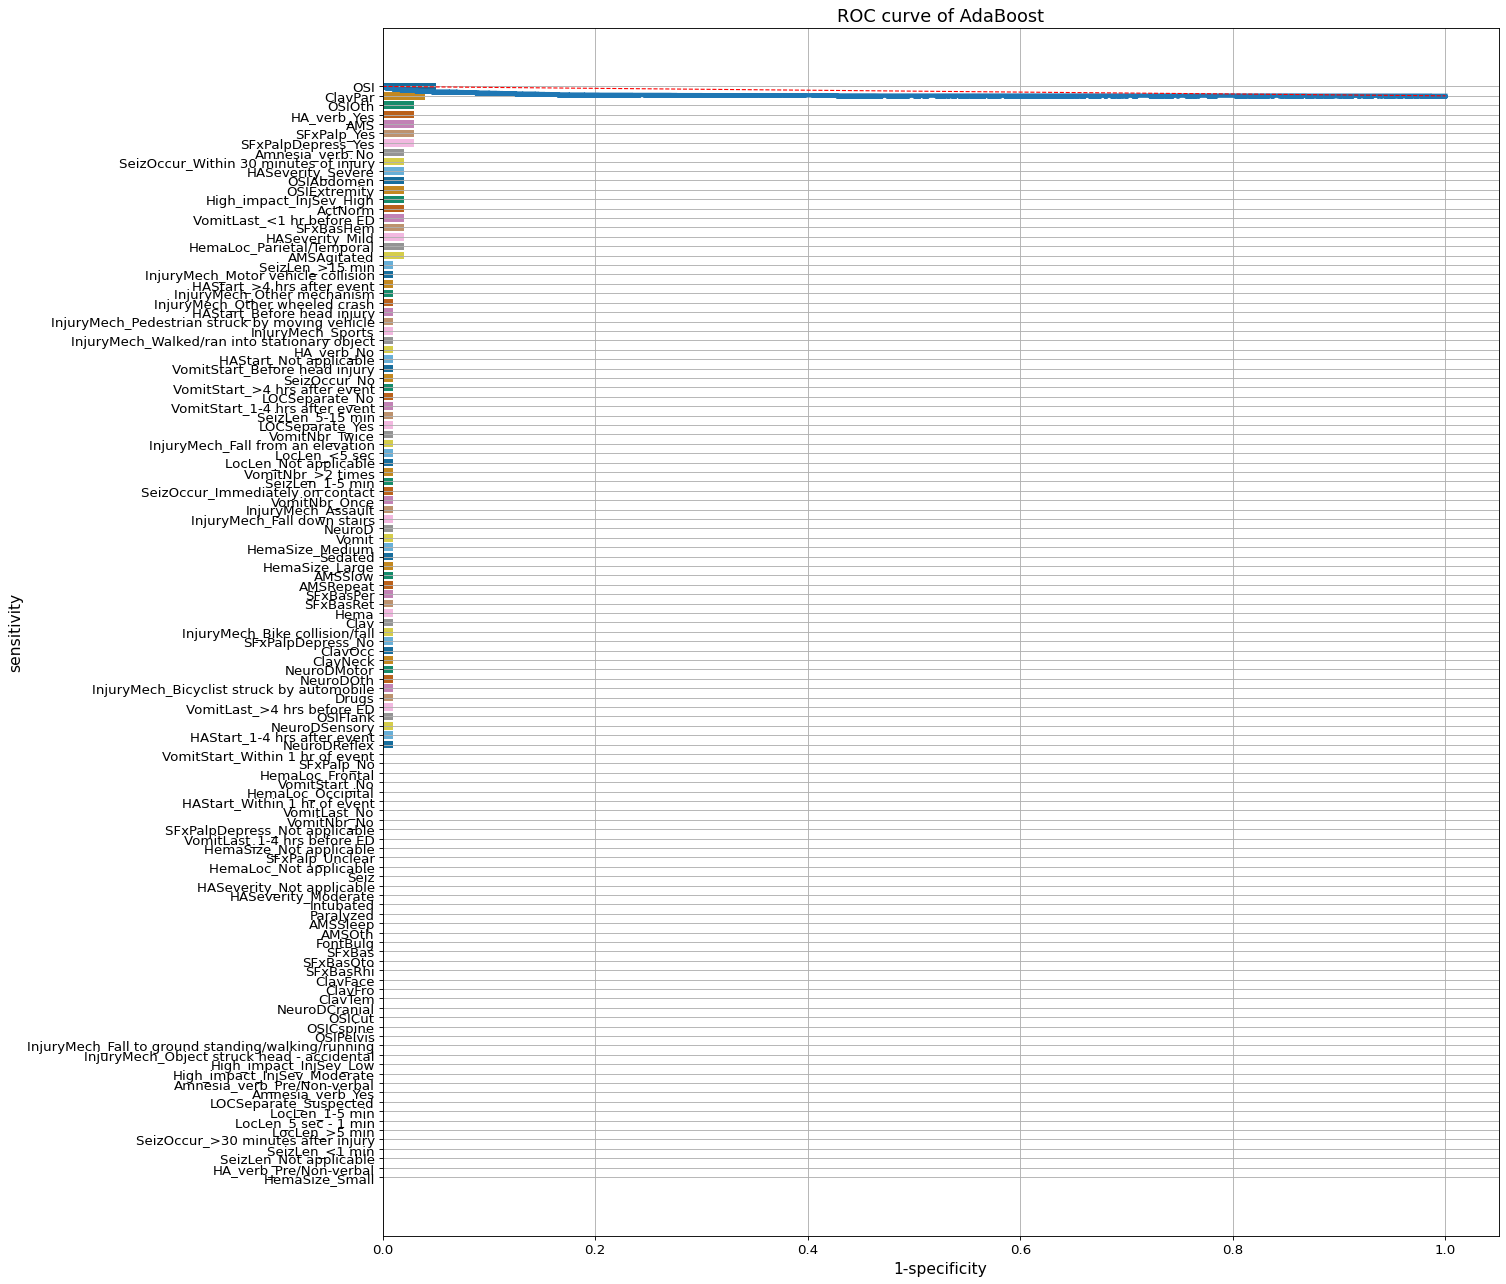

/Users/aprasad/Library/Python/3.9/lib/python/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


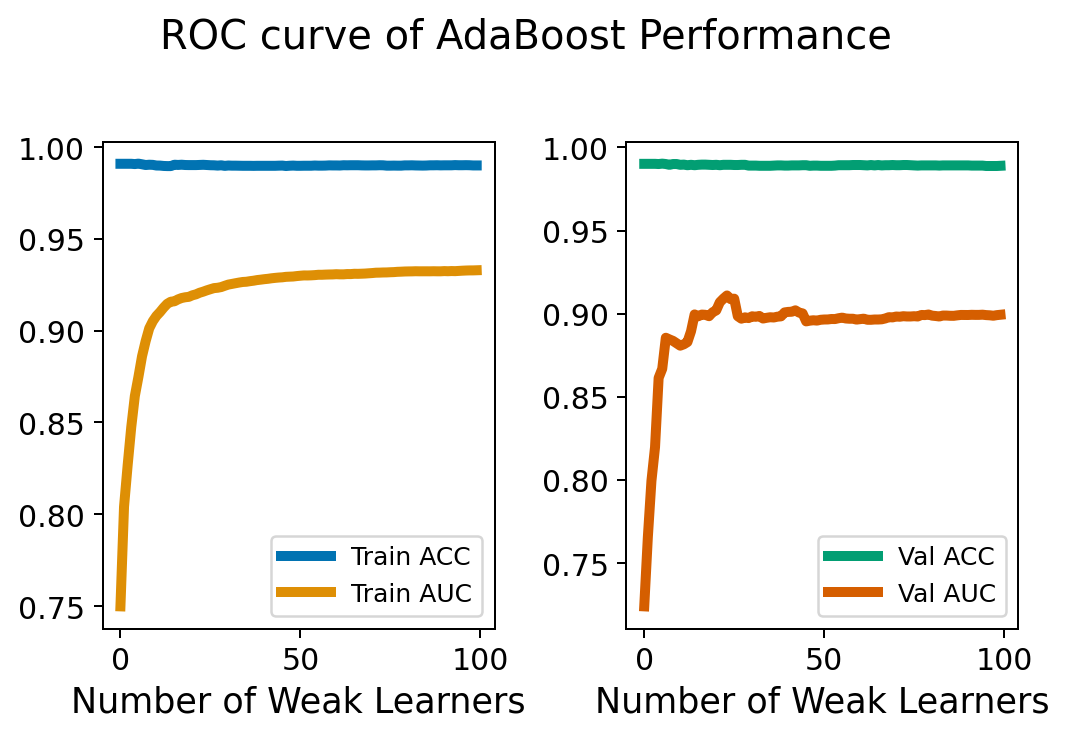

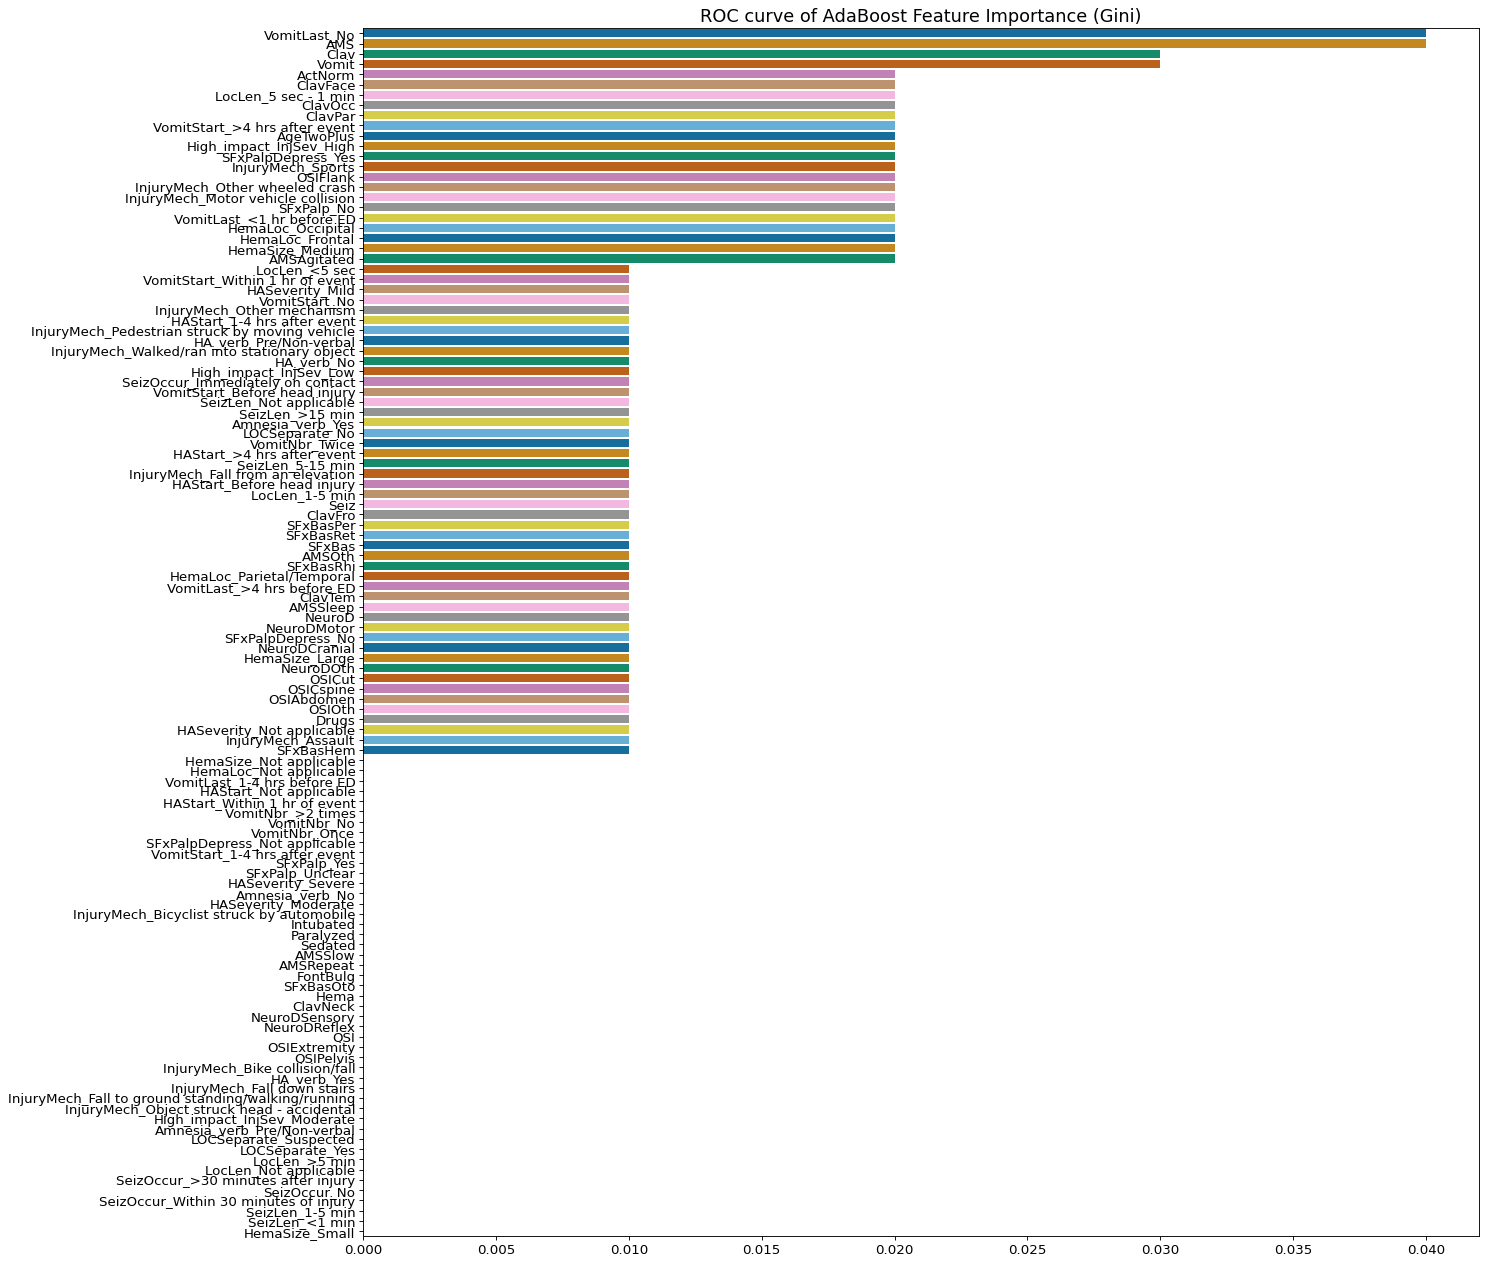

In [8]:
# AdaBoost
ada_model_young, ada_stats_young = train_models (model_type = 'AdaBoost', title_str = None, simple = False, 
              which_age = 'young', hyper_dict = {'n_estimator' : 100})
ada_model_old, ada_stats_old = train_models (model_type = 'AdaBoost', title_str = None, simple = False, 
              which_age = 'old', hyper_dict = {'n_estimator' : 100})
ada_model_all, ada_stats_all = train_models (model_type = 'AdaBoost', title_str = None, simple = False, 
              which_age = 'all', hyper_dict = {'n_estimator' : 100})

kwargs {'clean_data': {}, 'preprocess_data': {'infer_outcome': True, 'drop_low_gcs': True, 'impute_unknowns': 'mode', 'impute_not_applicables': True}, 'extract_features': {}}


100%|████████████████████████████████████████████| 7/7 [00:00<00:00, 191.35it/s]


Confusion Matrix : 
 [[  10    4]
 [ 233 1897]]
Prob. threshold : 0.00000
AUC             : 0.825
Accuracy        : 0.889
Sensitivity     : 0.714
Specificity     : 0.891
Balanced Acc.   : 0.802
NPV             : 0.998


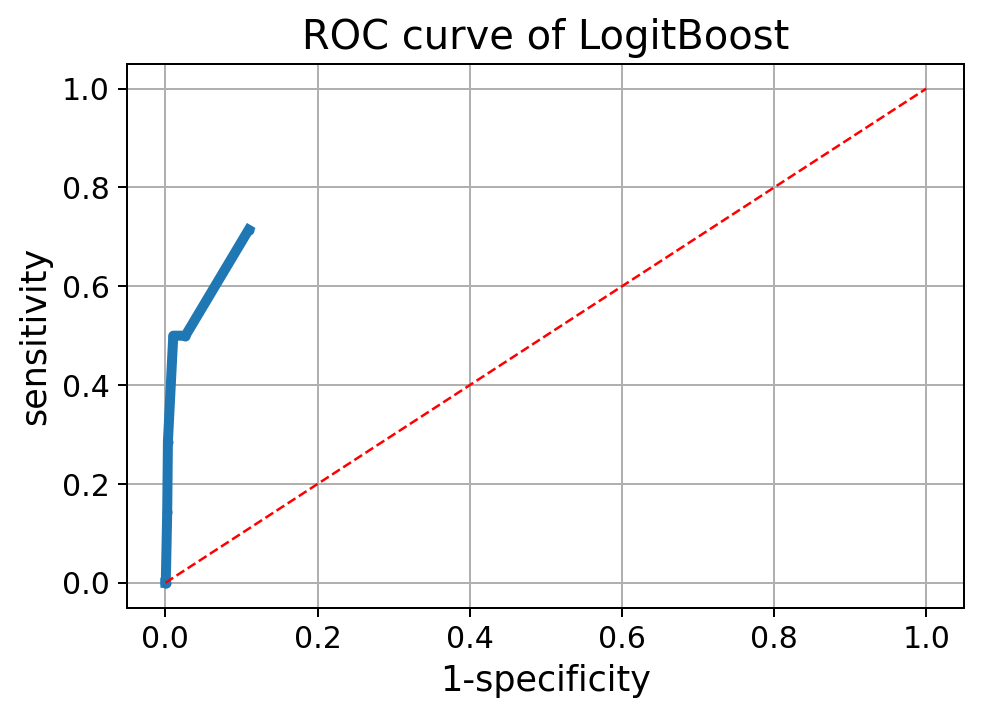

kwargs {'clean_data': {}, 'preprocess_data': {'infer_outcome': True, 'drop_low_gcs': True, 'impute_unknowns': 'mode', 'impute_not_applicables': True}, 'extract_features': {}}


100%|███████████████████████████████████████| 2436/2436 [00:33<00:00, 71.89it/s]


Confusion Matrix : 
 [[  45    2]
 [4986 1309]]
Prob. threshold : 0.00000
AUC             : 0.814
Accuracy        : 0.213
Sensitivity     : 0.957
Specificity     : 0.208
Balanced Acc.   : 0.583
NPV             : 0.998


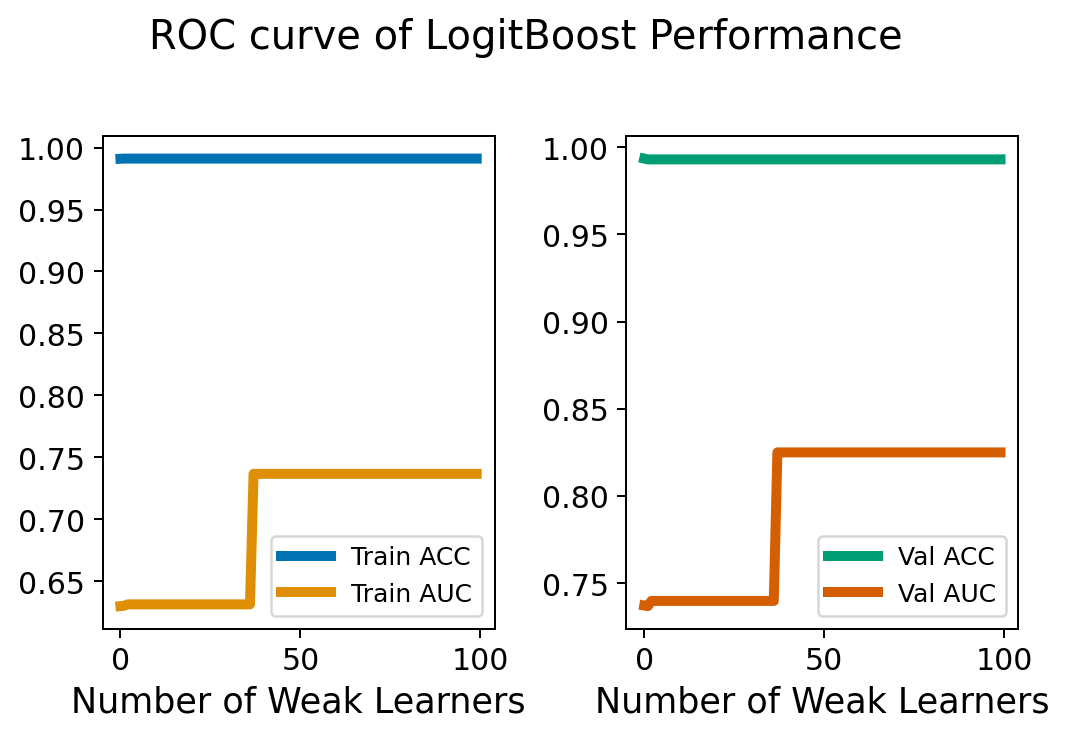

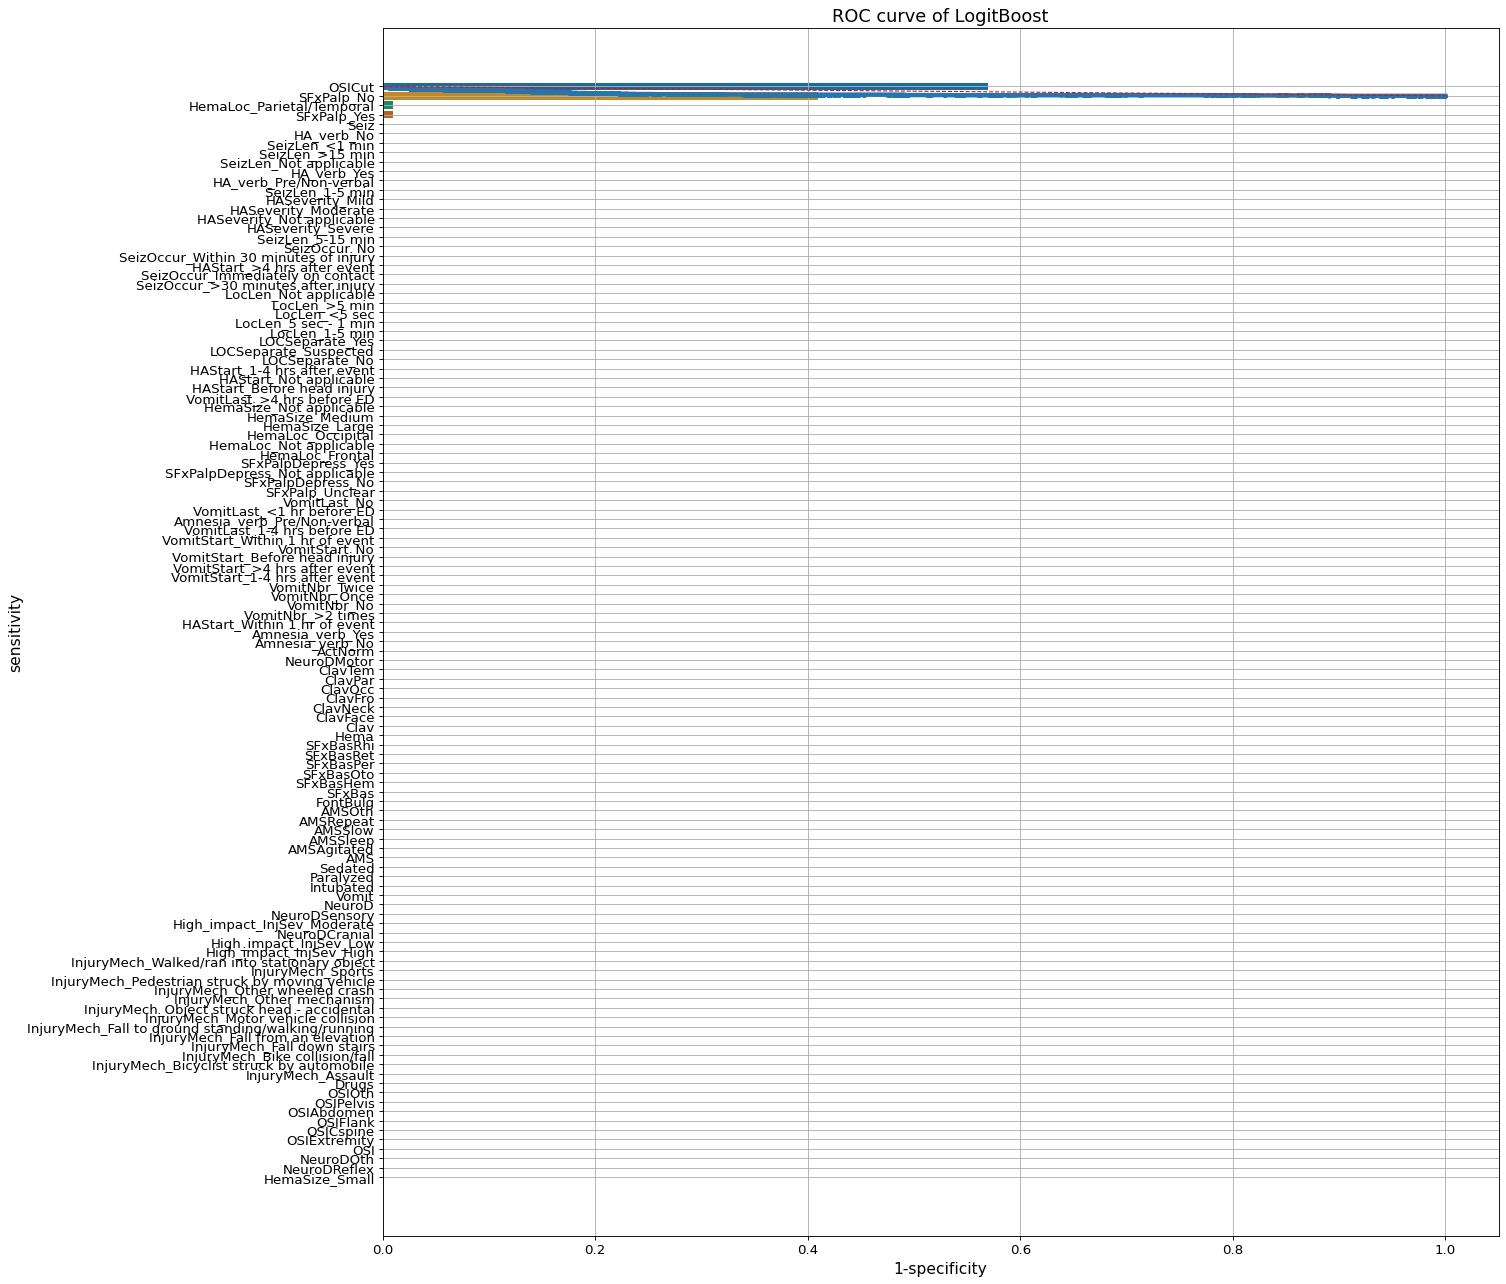

kwargs {'clean_data': {}, 'preprocess_data': {'infer_outcome': True, 'drop_low_gcs': True, 'impute_unknowns': 'mode', 'impute_not_applicables': True}, 'extract_features': {}}


100%|███████████████████████████████████████| 3945/3945 [01:11<00:00, 55.26it/s]


Confusion Matrix : 
 [[  80    4]
 [6800 1602]]
Prob. threshold : 0.00000
AUC             : 0.746
Accuracy        : 0.198
Sensitivity     : 0.952
Specificity     : 0.191
Balanced Acc.   : 0.572
NPV             : 0.998


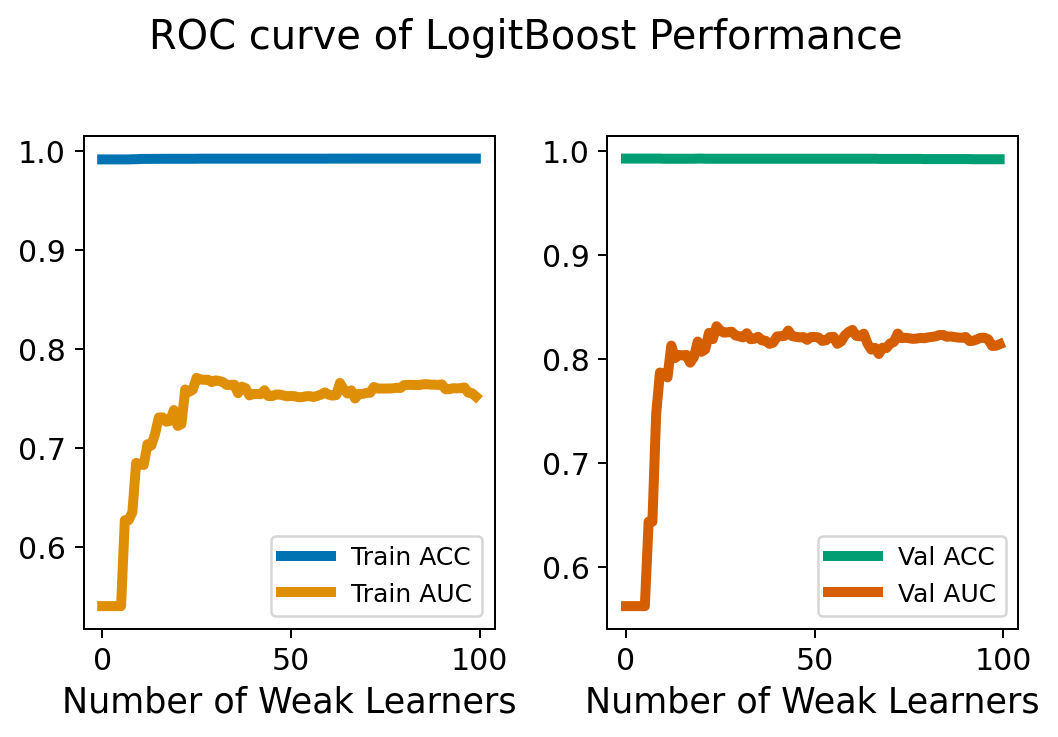

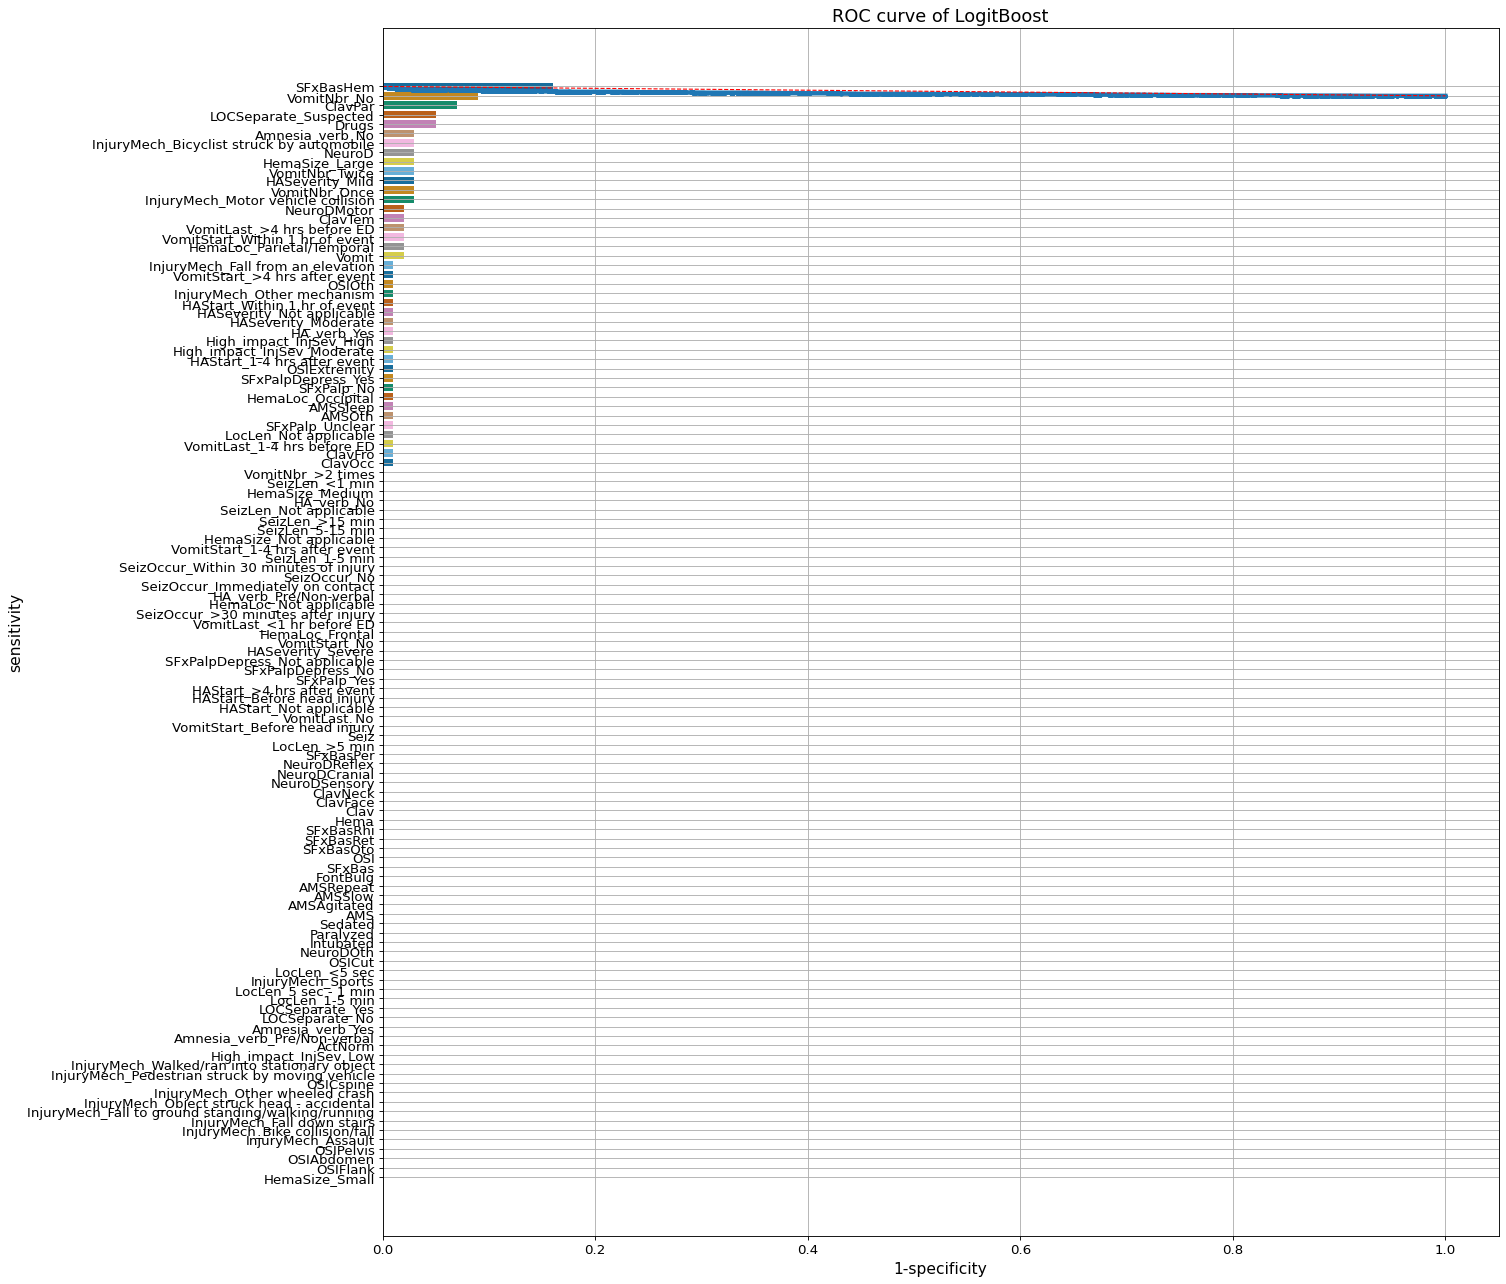

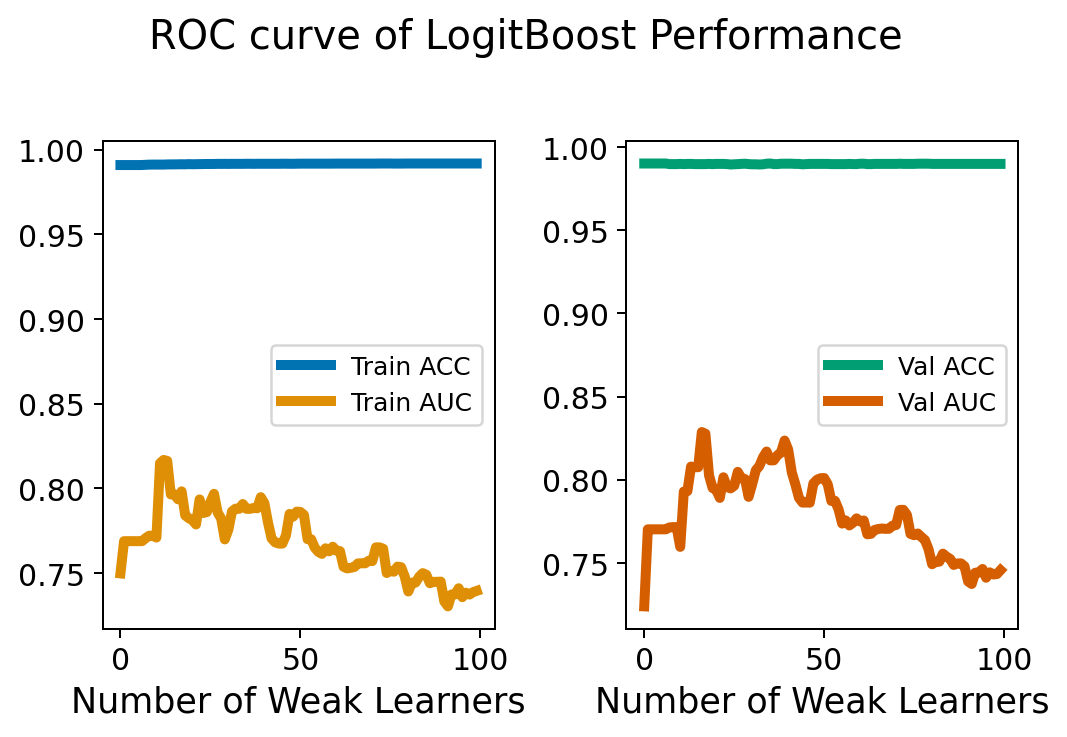

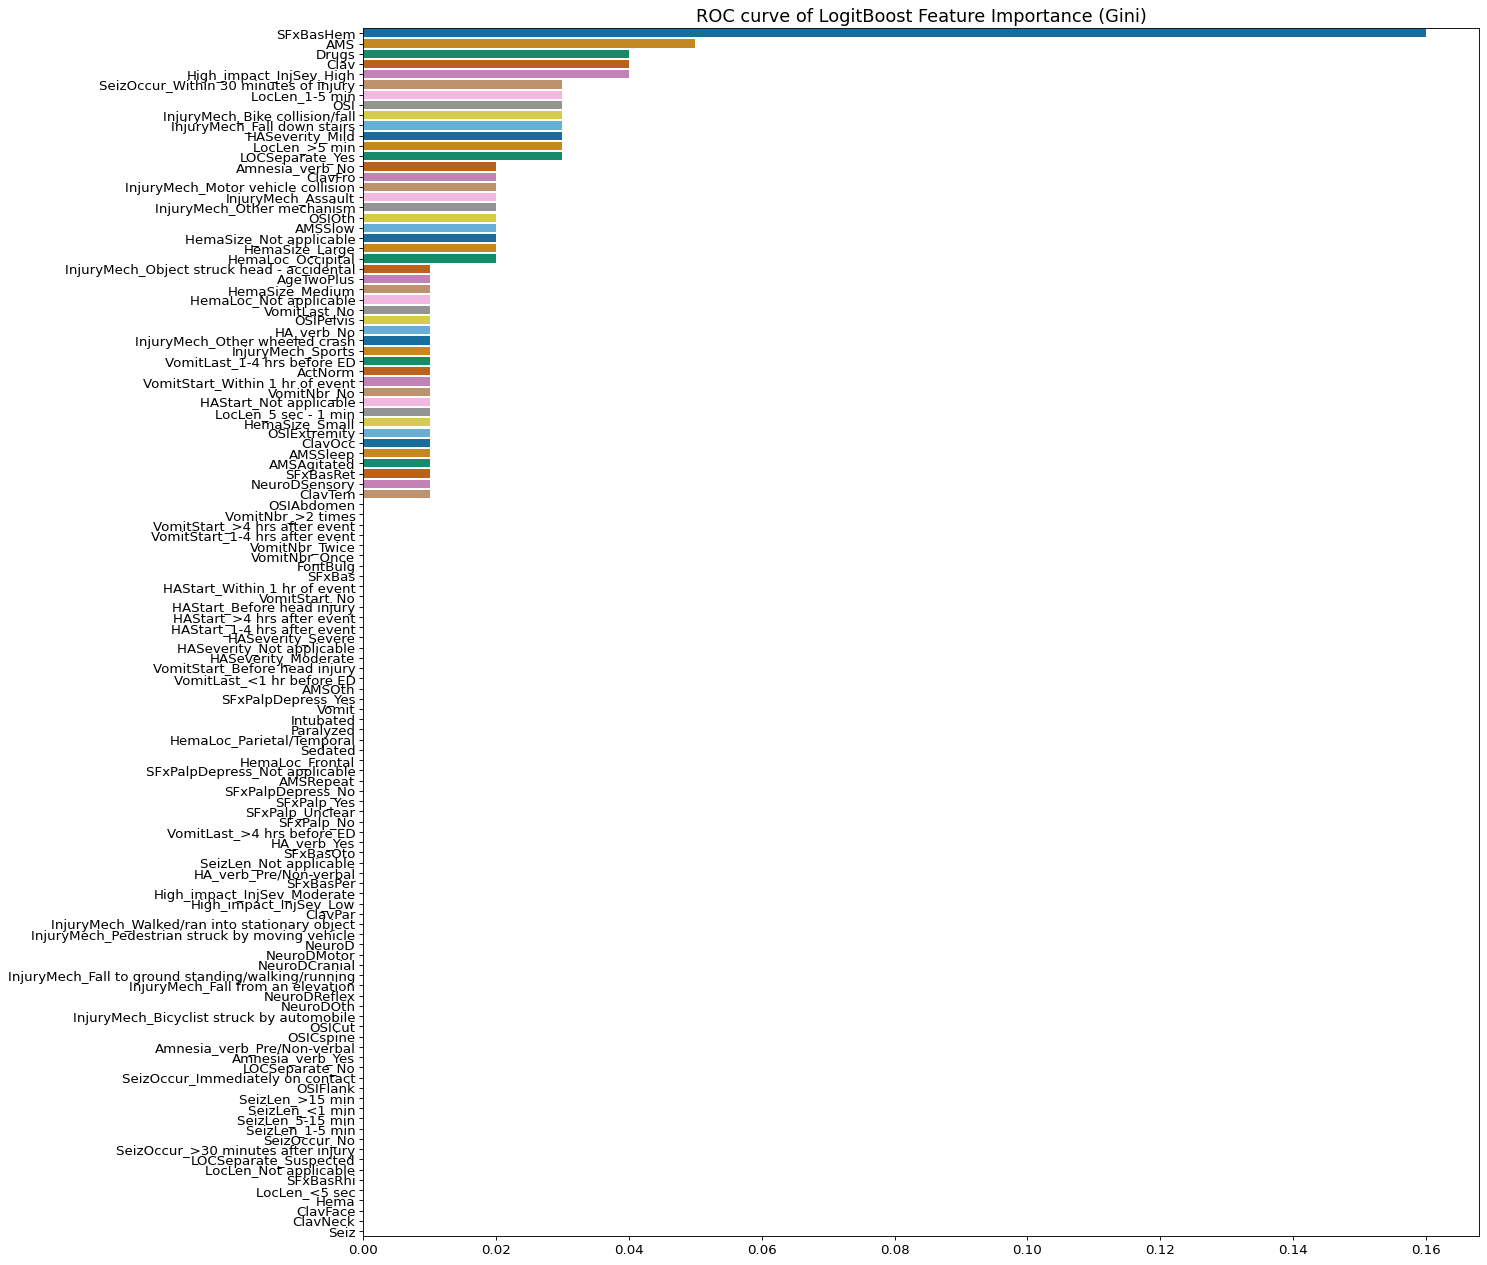

In [9]:
# LogitBoost
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    lb_model_young, lb_stats_young = train_models (model_type = 'LogitBoost', title_str = None, simple = False, 
              which_age = 'young', hyper_dict = {'n_estimator' : 100})
    lb_model_old, lb_stats_old = train_models (model_type = 'LogitBoost', title_str = None, simple = False, 
              which_age = 'old', hyper_dict = {'n_estimator' : 100})
    lb_model_all, lb_stats_all = train_models (model_type = 'LogitBoost', title_str = None, simple = False, 
              which_age = 'all', hyper_dict = {'n_estimator' : 100})

kwargs {'clean_data': {}, 'preprocess_data': {'infer_outcome': True, 'drop_low_gcs': True, 'impute_unknowns': 'mode', 'impute_not_applicables': True}, 'extract_features': {}}


100%|██████████████████████████████████████████| 12/12 [00:00<00:00, 203.59it/s]


Confusion Matrix : 
 [[  13    1]
 [1890  240]]
Prob. threshold : 0.00000
AUC             : 0.898
Accuracy        : 0.118
Sensitivity     : 0.929
Specificity     : 0.113
Balanced Acc.   : 0.521
NPV             : 0.996


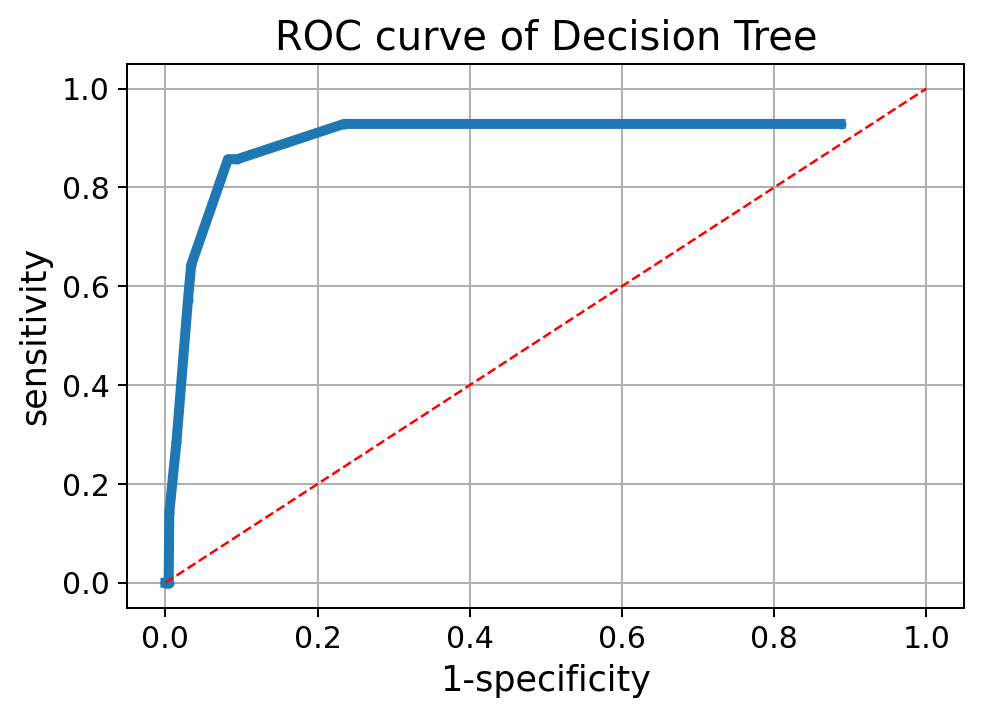

kwargs {'clean_data': {}, 'preprocess_data': {'infer_outcome': True, 'drop_low_gcs': True, 'impute_unknowns': 'mode', 'impute_not_applicables': True}, 'extract_features': {}}


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 73.17it/s]


Confusion Matrix : 
 [[  45    2]
 [1751 4544]]
Prob. threshold : 0.00231
AUC             : 0.875
Accuracy        : 0.724
Sensitivity     : 0.957
Specificity     : 0.722
Balanced Acc.   : 0.840
NPV             : 1.000


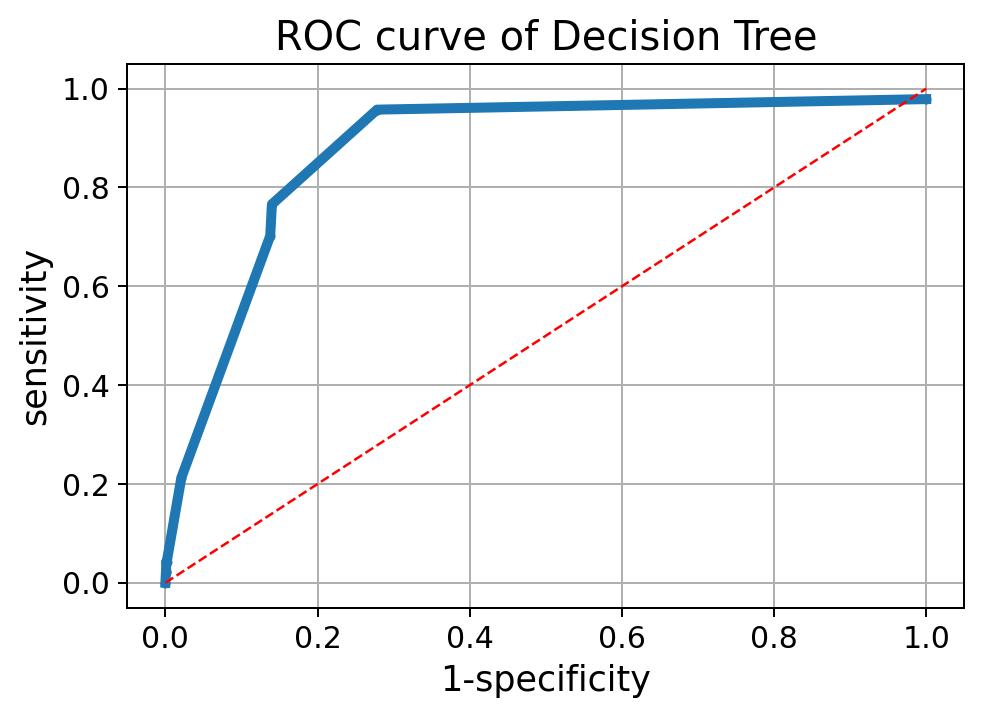

kwargs {'clean_data': {}, 'preprocess_data': {'infer_outcome': True, 'drop_low_gcs': True, 'impute_unknowns': 'mode', 'impute_not_applicables': True}, 'extract_features': {}}


100%|███████████████████████████████████████████| 17/17 [00:00<00:00, 56.59it/s]


Confusion Matrix : 
 [[  83    1]
 [8399    3]]
Prob. threshold : 0.00000
AUC             : 0.809
Accuracy        : 0.010
Sensitivity     : 0.988
Specificity     : 0.000
Balanced Acc.   : 0.494
NPV             : 0.750


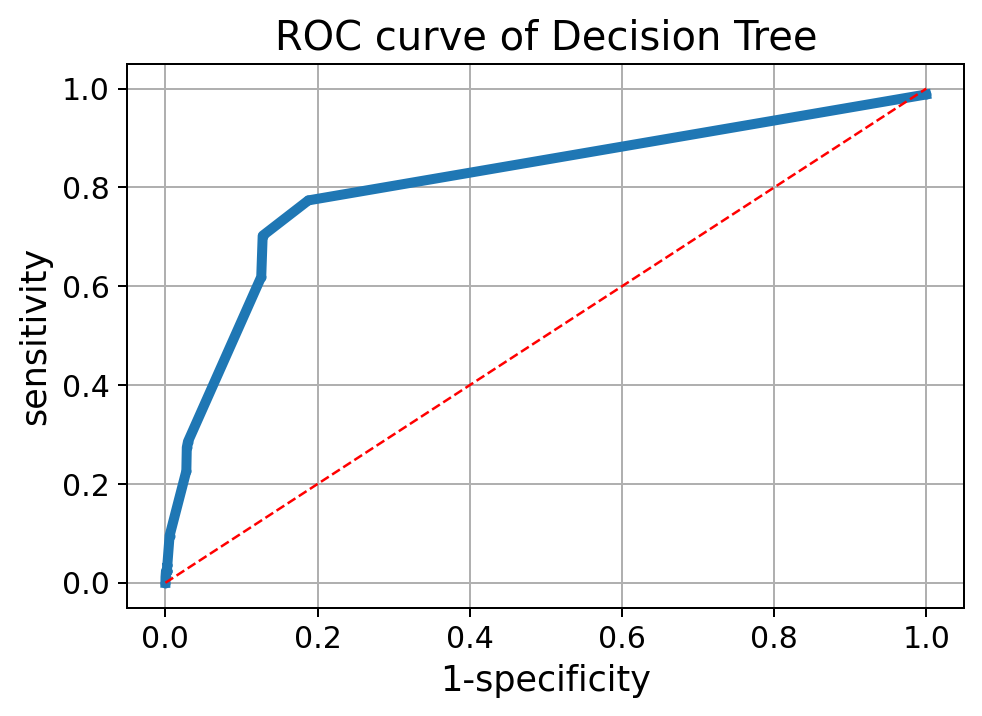

In [10]:
# Decision Tree
dt_model_young, dt_stats_young = train_models (model_type = 'Decision Tree', title_str = None, simple = False, 
              which_age = 'young', hyper_dict = {'depth' : list(range(1, 6)), 'weight_ratio' : [1, 100]})
dt_model_old, dt_stats_old = train_models (model_type = 'Decision Tree', title_str = None, simple = False, 
              which_age = 'old', hyper_dict = {'depth' : list(range(1, 6)), 'weight_ratio' : [1, 100]})
dt_model_all, dt_stats_all = train_models (model_type = 'Decision Tree', title_str = None, simple = False, 
              which_age = 'all', hyper_dict = {'depth' : list(range(1, 6)), 'weight_ratio' : [1, 100]})

kwargs {'clean_data': {}, 'preprocess_data': {'infer_outcome': True, 'drop_low_gcs': True, 'impute_unknowns': 'mode', 'impute_not_applicables': True}, 'extract_features': {}}


100%|████████████████████████████████████████| 100/100 [00:00<00:00, 203.19it/s]


Confusion Matrix : 
 [[  10    4]
 [ 331 1799]]
Prob. threshold : 0.00000
AUC             : 0.815
Accuracy        : 0.844
Sensitivity     : 0.714
Specificity     : 0.845
Balanced Acc.   : 0.779
NPV             : 0.998


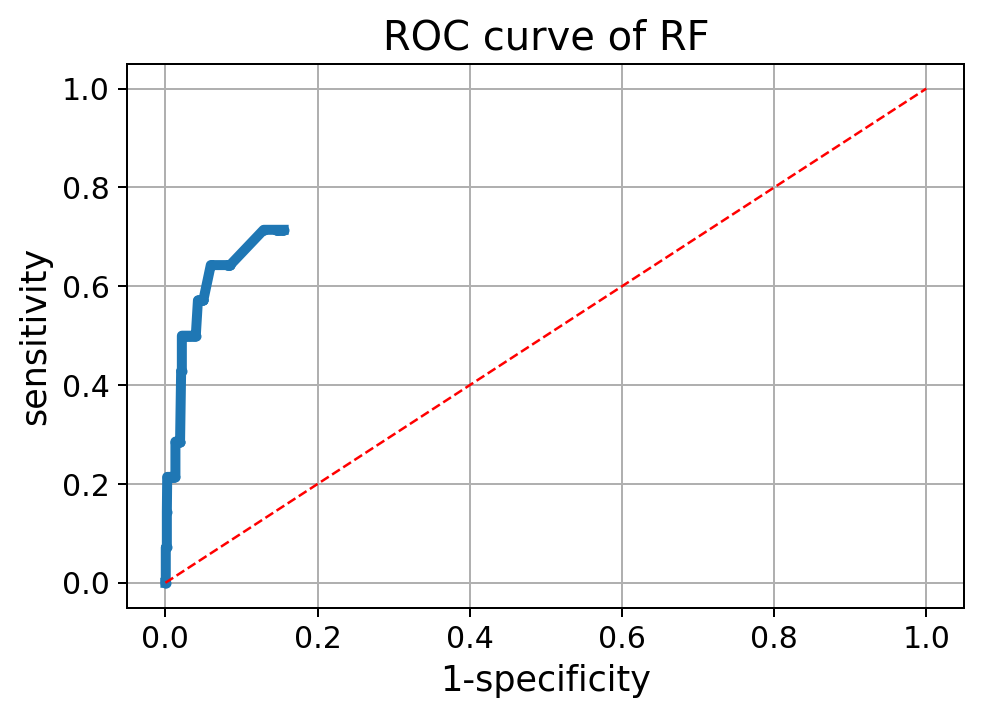

kwargs {'clean_data': {}, 'preprocess_data': {'infer_outcome': True, 'drop_low_gcs': True, 'impute_unknowns': 'mode', 'impute_not_applicables': True}, 'extract_features': {}}


100%|███████████████████████████████████████████| 83/83 [00:01<00:00, 76.93it/s]


Confusion Matrix : 
 [[  42    5]
 [1291 5004]]
Prob. threshold : 0.00000
AUC             : 0.889
Accuracy        : 0.796
Sensitivity     : 0.894
Specificity     : 0.795
Balanced Acc.   : 0.844
NPV             : 0.999


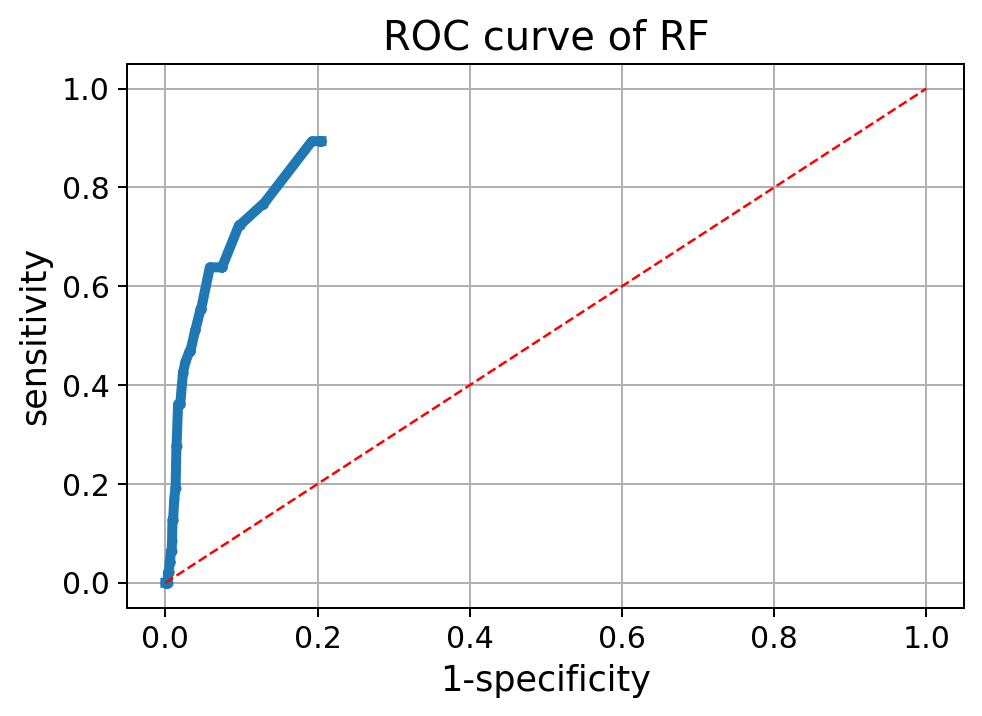

kwargs {'clean_data': {}, 'preprocess_data': {'infer_outcome': True, 'drop_low_gcs': True, 'impute_unknowns': 'mode', 'impute_not_applicables': True}, 'extract_features': {}}


100%|█████████████████████████████████████████| 146/146 [00:02<00:00, 55.03it/s]


Confusion Matrix : 
 [[  67   17]
 [1547 6855]]
Prob. threshold : 0.00000
AUC             : 0.845
Accuracy        : 0.816
Sensitivity     : 0.798
Specificity     : 0.816
Balanced Acc.   : 0.807
NPV             : 0.998


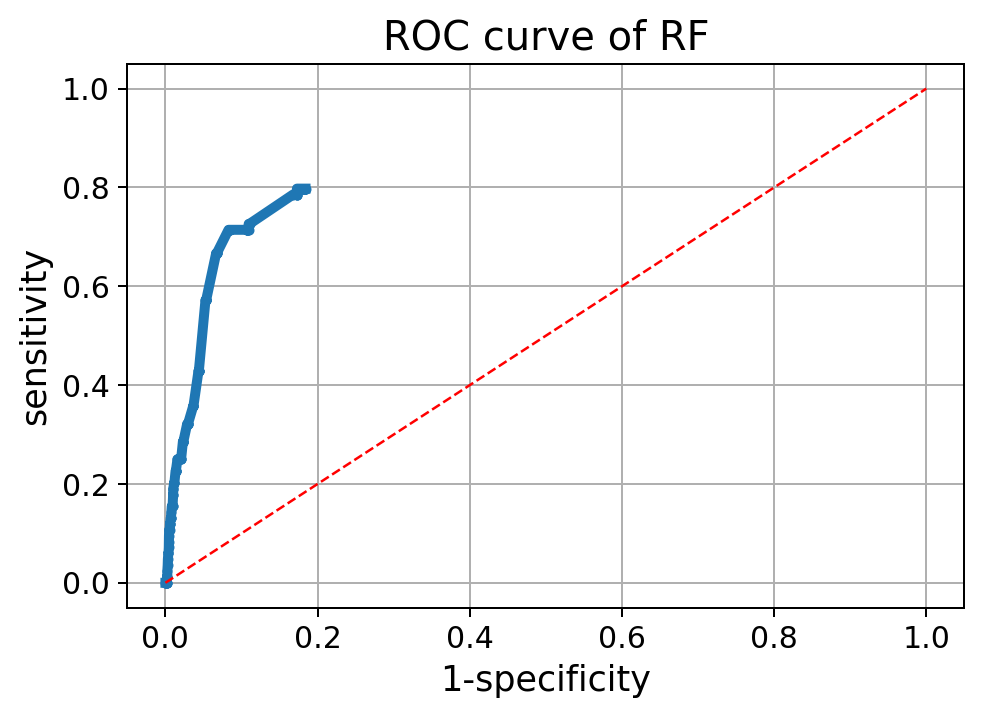

In [11]:
# RF
rf_model_young, rf_stats_young = train_models (model_type = 'RF', title_str = None, simple = False, 
                                               which_age = 'young')
rf_model_old, rf_stats_old = train_models (model_type = 'RF', title_str = None, simple = False, 
                                               which_age = 'old')
rf_model_all, rf_stats_all = train_models (model_type = 'RF', title_str = None, simple = False, 
                                               which_age = 'all')

kwargs {'clean_data': {}, 'preprocess_data': {'infer_outcome': True, 'drop_low_gcs': True, 'impute_unknowns': 'mode', 'impute_not_applicables': True}, 'extract_features': {}}


100%|██████████████████████████████████████| 1086/1086 [00:06<00:00, 180.25it/s]


Confusion Matrix : 
 [[  14    0]
 [2113   17]]
Prob. threshold : 0.00861
AUC             : 0.275
Accuracy        : 0.014
Sensitivity     : 1.000
Specificity     : 0.008
Balanced Acc.   : 0.504
NPV             : 1.000


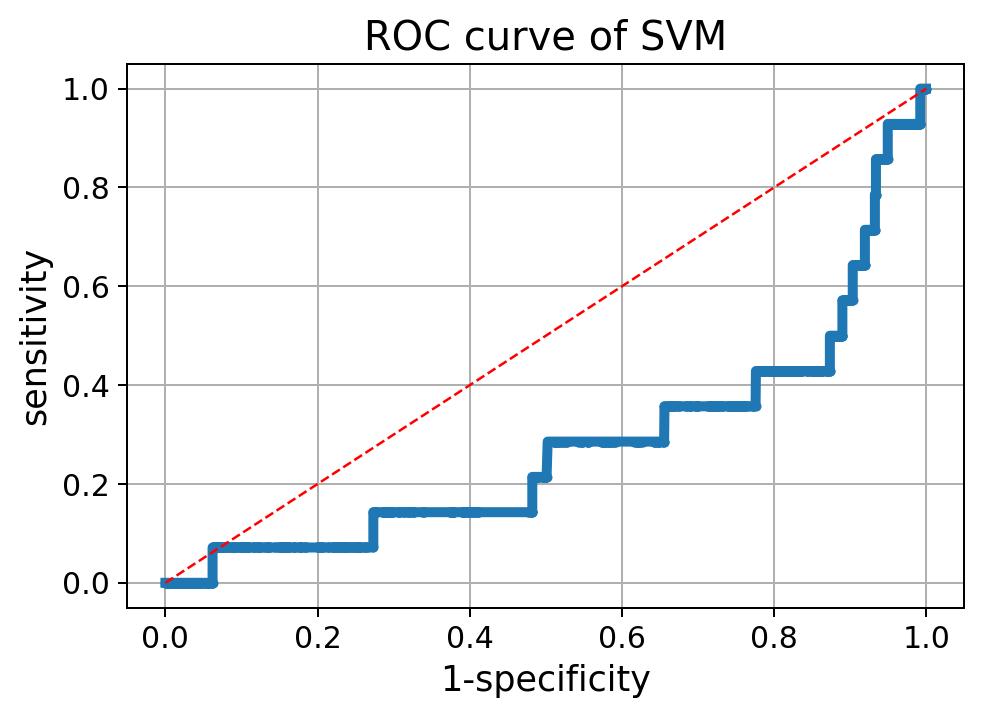

kwargs {'clean_data': {}, 'preprocess_data': {'infer_outcome': True, 'drop_low_gcs': True, 'impute_unknowns': 'mode', 'impute_not_applicables': True}, 'extract_features': {}}


100%|███████████████████████████████████████| 4210/4210 [00:58<00:00, 72.13it/s]


Confusion Matrix : 
 [[  45    2]
 [5976  319]]
Prob. threshold : 0.00384
AUC             : 0.645
Accuracy        : 0.057
Sensitivity     : 0.957
Specificity     : 0.051
Balanced Acc.   : 0.504
NPV             : 0.994


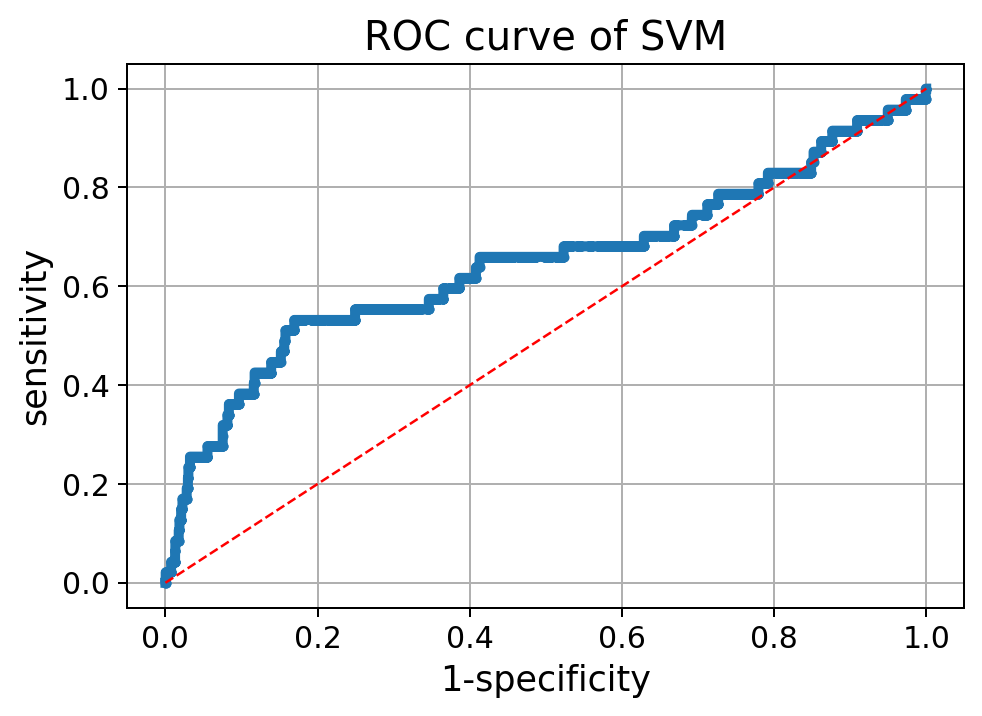

kwargs {'clean_data': {}, 'preprocess_data': {'infer_outcome': True, 'drop_low_gcs': True, 'impute_unknowns': 'mode', 'impute_not_applicables': True}, 'extract_features': {}}


100%|███████████████████████████████████████| 5207/5207 [01:33<00:00, 55.51it/s]


Confusion Matrix : 
 [[  80    4]
 [7947  455]]
Prob. threshold : 0.00609
AUC             : 0.644
Accuracy        : 0.063
Sensitivity     : 0.952
Specificity     : 0.054
Balanced Acc.   : 0.503
NPV             : 0.991


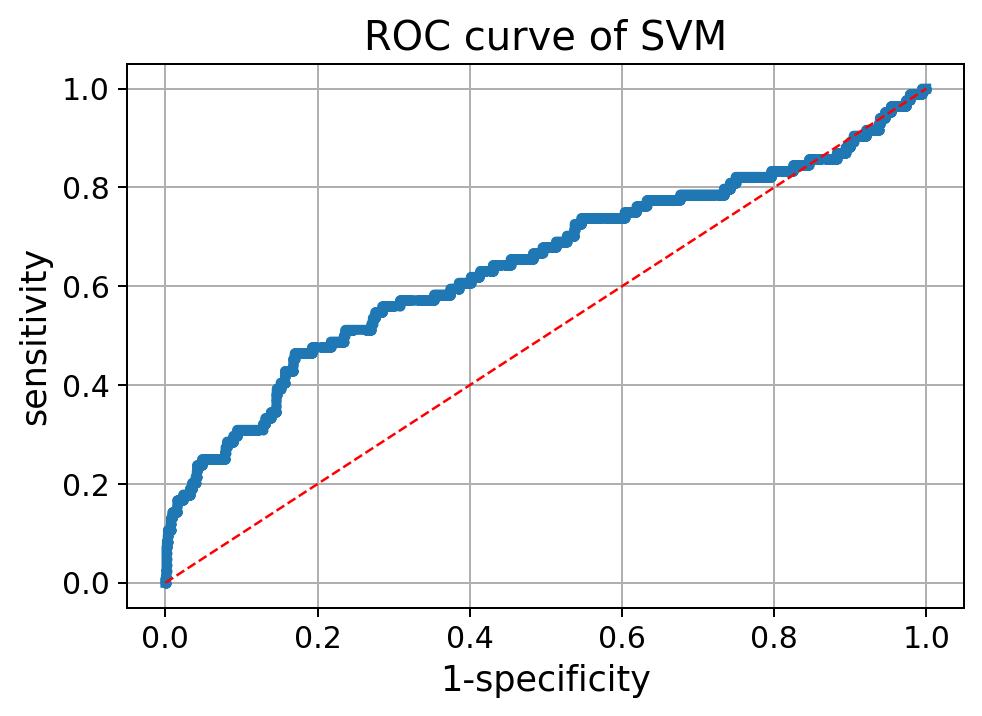

In [12]:
# SVM
svm_model_young, svm_stats_young = train_models (model_type = 'SVM', title_str = None, simple = False, 
              which_age = 'young', hyper_dict = {'gamma_vec' : [0.125, 0.25]})
svm_model_old, svm_stats_old = train_models (model_type = 'SVM', title_str = None, simple = False, 
              which_age = 'old', hyper_dict = {'gamma_vec' : [0.125, 0.25]})
svm_model_all, svm_stats_all = train_models (model_type = 'SVM', title_str = None, simple = False, 
              which_age = 'all', hyper_dict = {'gamma_vec' : [0.125, 0.25]})

## Baseline implementation

In [13]:
def add_binary_variables(data) :
    
    df = data.copy()
    
    df['HemaBinary'] = np.maximum.reduce([df['HemaLoc_Occipital'], df['HemaLoc_Parietal/Temporal']])
    df['LocBinary'] = np.maximum.reduce([df['LocLen_5 sec - 1 min'], df['LocLen_1-5 min'], df['LocLen_>5 min']])
    df['MechBinary'] = df['High_impact_InjSev_High']
    df['HABinary'] = df['HASeverity_Severe']
    df['SeizLen'] = np.maximum.reduce([df['SeizLen_1-5 min'], df['SeizLen_5-15 min'], df['SeizLen_>15 min']])
    df['HemaSizeBinary'] = np.maximum.reduce([df['HemaSize_Large'], df['HemaSize_Medium']])
    df['LocSeparateBinary'] = np.maximum.reduce([df['LOCSeparate_Suspected'], df['LOCSeparate_Yes']])
    df['SFxPalpBinary'] = np.maximum.reduce([df['SFxPalp_Unclear'], df['SFxPalp_Yes']])
    
    return df

def baseline_pred(df) :
    
    young_pred = 100 * df['AgeTwoPlus'] + df.loc[:, ['AMS', 'HemaBinary', 'LocBinary', 'MechBinary', 'SFxPalpBinary']].sum(axis=1) + 1 - df['ActNorm']
    old_pred = 100 * df['AgeTwoPlus'] + df.loc[:, ['AMS', 'LocBinary', 'Vomit', 'MechBinary', 'SFxBas', 'HABinary']].sum(axis=1)
    pred = (young_pred != 100.0) & (old_pred != 200.0)
    
    return pred

In [14]:
# Load data

_, df_tune_young, _ = Dataset().get_data(simple = False, young = True, old = False)
_, df_tune_old, _ = Dataset().get_data(simple = False, young = False, old = True)
_, df_tune_all, _ = Dataset().get_data(simple = False, young = True, old = True)

df_tune_young = add_binary_variables(df_tune_young)
df_tune_young["AgeTwoPlus"] = 1
df_tune_old = add_binary_variables(df_tune_old)
df_tune_old["AgeTwoPlus"] = 2
df_tune_all = add_binary_variables(df_tune_all)
df_tune_all["AgeTwoPlus"] = 2

y_tune_young_pred = baseline_pred(df_tune_young)
y_tune_old_pred = baseline_pred(df_tune_old)
y_tune_all_pred = baseline_pred(df_tune_all)

baseline_stats = []
for y_tune, y_pred in zip([y_tune_young, y_tune_old, y_tune_all], [y_tune_young_pred, y_tune_old_pred, y_tune_all_pred]):
    cm = confusion_matrix(y_tune, y_pred, labels=[1, 0])
    
    # Calculating statistics
    n = sum(sum(cm))
    auc = roc_auc_score(y_tune, y_pred)
    acc = (cm[0,0] + cm[1,1]) / n
    sens = cm[0,0] / (cm[0,0] + cm[0,1])
    spec = cm[1,1] / (cm[1,0] + cm[1,1])
    npv = cm[1, 1] / (cm[1, 1] + cm[0, 1])
    balacc = (sens + spec) / 2
    
    baseline_stats.append({'AUC' : auc, 'Accuracy' : acc, 'Balanced Accuracy' : balacc, 
                "Sensitivity" : sens, "Specificity" : spec, "NPV" : npv})

print(baseline_stats)

kwargs {'clean_data': {}, 'preprocess_data': {'infer_outcome': True, 'drop_low_gcs': True, 'impute_unknowns': 'mode', 'impute_not_applicables': True}, 'extract_features': {}}
kwargs {'clean_data': {}, 'preprocess_data': {'infer_outcome': True, 'drop_low_gcs': True, 'impute_unknowns': 'mode', 'impute_not_applicables': True}, 'extract_features': {}}
kwargs {'clean_data': {}, 'preprocess_data': {'infer_outcome': True, 'drop_low_gcs': True, 'impute_unknowns': 'mode', 'impute_not_applicables': True}, 'extract_features': {}}
[{'AUC': 0.7711267605633803, 'Accuracy': 0.5452425373134329, 'Balanced Accuracy': 0.7711267605633803, 'Sensitivity': 1.0, 'Specificity': 0.5422535211267606, 'NPV': 1.0}, {'AUC': 0.7850776536596084, 'Accuracy': 0.6152633238725954, 'Balanced Accuracy': 0.7850776536596082, 'Sensitivity': 0.9574468085106383, 'Specificity': 0.6127084988085783, 'NPV': 0.9994817310183985}, {'AUC': 0.7696282631119574, 'Accuracy': 0.6255008248880509, 'Balanced Accuracy': 0.7696282631119575, 'Sens

In [34]:
# Load data

_, _, df_test_young = Dataset().get_data(simple = False, young = True, old = False)
_, _, df_test_old = Dataset().get_data(simple = False, young = False, old = True)
_, _, df_test_all = Dataset().get_data(simple = False, young = True, old = True)

df_test_young = add_binary_variables(df_test_young)
df_test_young["AgeTwoPlus"] = 1
df_test_old = add_binary_variables(df_test_old)
df_test_old["AgeTwoPlus"] = 2
df_test_all = add_binary_variables(df_test_all)
df_test_all["AgeTwoPlus"] = 2

y_test_young_pred = baseline_pred(df_test_young)
y_test_old_pred = baseline_pred(df_test_old)
y_test_all_pred = baseline_pred(df_test_all)

baseline_stats_test = []
for y_test, y_pred in zip([y_test_young, y_test_old, y_test_all], [y_test_young_pred, y_test_old_pred, y_test_all_pred]):
    cm = confusion_matrix(y_test, y_pred, labels=[1, 0])
    
    # Calculating statistics
    n = sum(sum(cm))
    auc = roc_auc_score(y_test, y_pred)
    acc = (cm[0,0] + cm[1,1]) / n
    sens = cm[0,0] / (cm[0,0] + cm[0,1])
    spec = cm[1,1] / (cm[1,0] + cm[1,1])
    npv = cm[1, 1] / (cm[1, 1] + cm[0, 1])
    balacc = (sens + spec) / 2
    
    baseline_stats_test.append({'AUC' : auc, 'Accuracy' : acc, 'Balanced Accuracy' : balacc, 
                "Sensitivity" : sens, "Specificity" : spec, "NPV" : npv})

print(baseline_stats_test)





kwargs {'clean_data': {}, 'preprocess_data': {'infer_outcome': True, 'drop_low_gcs': True, 'impute_unknowns': 'mode', 'impute_not_applicables': True}, 'extract_features': {}}
kwargs {'clean_data': {}, 'preprocess_data': {'infer_outcome': True, 'drop_low_gcs': True, 'impute_unknowns': 'mode', 'impute_not_applicables': True}, 'extract_features': {}}
kwargs {'clean_data': {}, 'preprocess_data': {'infer_outcome': True, 'drop_low_gcs': True, 'impute_unknowns': 'mode', 'impute_not_applicables': True}, 'extract_features': {}}
[{'AUC': 0.7744218971212836, 'Accuracy': 0.5543123543123543, 'Balanced Accuracy': 0.7744218971212836, 'Sensitivity': 1.0, 'Specificity': 0.5488437942425672, 'NPV': 1.0}, {'AUC': 0.7860593512767426, 'Accuracy': 0.6385998107852412, 'Balanced Accuracy': 0.7860593512767426, 'Sensitivity': 0.9365079365079365, 'Specificity': 0.6356107660455487, 'NPV': 0.9989987484355445}, {'AUC': 0.7770749268138303, 'Accuracy': 0.6230261607353288, 'Balanced Accuracy': 0.7770749268138302, 'Sens

## Model summary

In [31]:
stats_df = pd.read_csv("./figs/model_val_results.csv")
stats_df = pd.DataFrame(columns=["Algorithm", "Age",
                                 "AUC", "Accuracy", "Sensitivity", "Specificity",
                                 "NPV", "Balanced Accuracy"
                                ])
alg_list = ["LR", "Group Lasso LR", "AdaBoost", "LogitBoost", "Decision Tree", "Random Forest", "SVM", "Baseline"]
age_list = ["young", "old", "all"] * len(alg_list)
alg_list = [val for val in alg_list for _ in range(3)]
for idx, st in enumerate([lr_stats_young,
    lr_stats_old,
    lr_stats_all,
    grlr_stats_young, grlr_stats_old, grlr_stats_all,
    ada_stats_young,
    ada_stats_old,
    ada_stats_all,
    lb_stats_young,
    lb_stats_old,
    lb_stats_all,
    dt_stats_young,
    dt_stats_old,
    dt_stats_all,
    rf_stats_young,
    rf_stats_old,
    rf_stats_all,
    svm_stats_young,
    svm_stats_old,
    svm_stats_all,
    baseline_stats[0], baseline_stats[1], baseline_stats[2]]):
    tmp_dict = {ky : st[ky] for ky in stats_df.columns if ky in st}
    tmp_dict["Algorithm"] = alg_list[idx]
    tmp_dict["Age"] = age_list[idx]
    
    stats_df = stats_df.append(tmp_dict, ignore_index=True)
np.round(stats_df, decimals=3).to_csv("./figs/model_val_results.csv", index=False)
stats_df



Algorithm    Age       AUC  Accuracy  Sensitivity  Specificity  \
0               LR  young  0.937844  0.763526     1.000000     0.761972   
1               LR    old  0.930598  0.751498     0.957447     0.749960   
2               LR    all  0.916742  0.750412     0.952381     0.748393   
3   Group Lasso LR  young  0.908065  0.728078     1.000000     0.726291   
4   Group Lasso LR    old  0.916501  0.679912     0.957447     0.677840   
5   Group Lasso LR    all  0.916728  0.744992     0.952381     0.742918   
6         AdaBoost  young  0.781154  0.064366     1.000000     0.058216   
7         AdaBoost    old  0.872143  0.249921     0.957447     0.244639   
8         AdaBoost    all  0.899335  0.590384     0.952381     0.586765   
9       LogitBoost  young  0.824916  0.889459     0.714286     0.890610   
10      LogitBoost    old  0.814094  0.213497     0.957447     0.207943   
11      LogitBoost    all  0.745693  0.198209     0.952381     0.190669   
12   Decision Tree  young  0.897770  0.118004     0.928571     0.112676   
13   Decision Tree    old  0.875445  0.723589     0.957447     0.721843   
14   Decision Tree    all  0.809002  0.010134     0.988095     0.000357   
15   Random Forest  young  0.814789  0.843750     0.714286     0.844601   
16   Random Forest    old  0.888892  0.795648     0.893617     0.794917   
17   Random Forest    all  0.844710  0.815696     0.797619     0.815877   
18             SVM  young  0.275469  0.014459     1.000000     0.007981   
19             SVM    old  0.645404  0.057395     0.957447     0.050675   
20             SVM    all  0.643991  0.063045     0.952381     0.054154   
21        Baseline  young  0.771127  0.545243     1.000000     0.542254   
22        Baseline    old  0.785078  0.615263     0.957447     0.612708   
23        Baseline    all  0.769628  0.625501     0.916667     0.622590   

         NPV  Balanced Accuracy  
0   1.000000           0.880986  
1   0.999577           0.853704  
2   0.999364           0.850387  
3   1.000000           0.863146  
4   0.999532           0.817643  
5   0.999360           0.847650  
6   1.000000           0.529108  
7   0.998703           0.601043  
8   0.999189           0.769573  
9   0.997896           0.802448  
10  0.998474           0.582695  
11  0.997509           0.571525  
12  0.995851           0.520624  
13  0.999560           0.839645  
14  0.750000           0.494226  
15  0.997781           0.779443  
16  0.999002           0.844267  
17  0.997526           0.806748  
18  1.000000           0.503991  
19  0.993769           0.504061  
20  0.991285           0.503267  
21  1.000000           0.771127  
22  0.999482           0.785078  
23  0.998664           0.769628

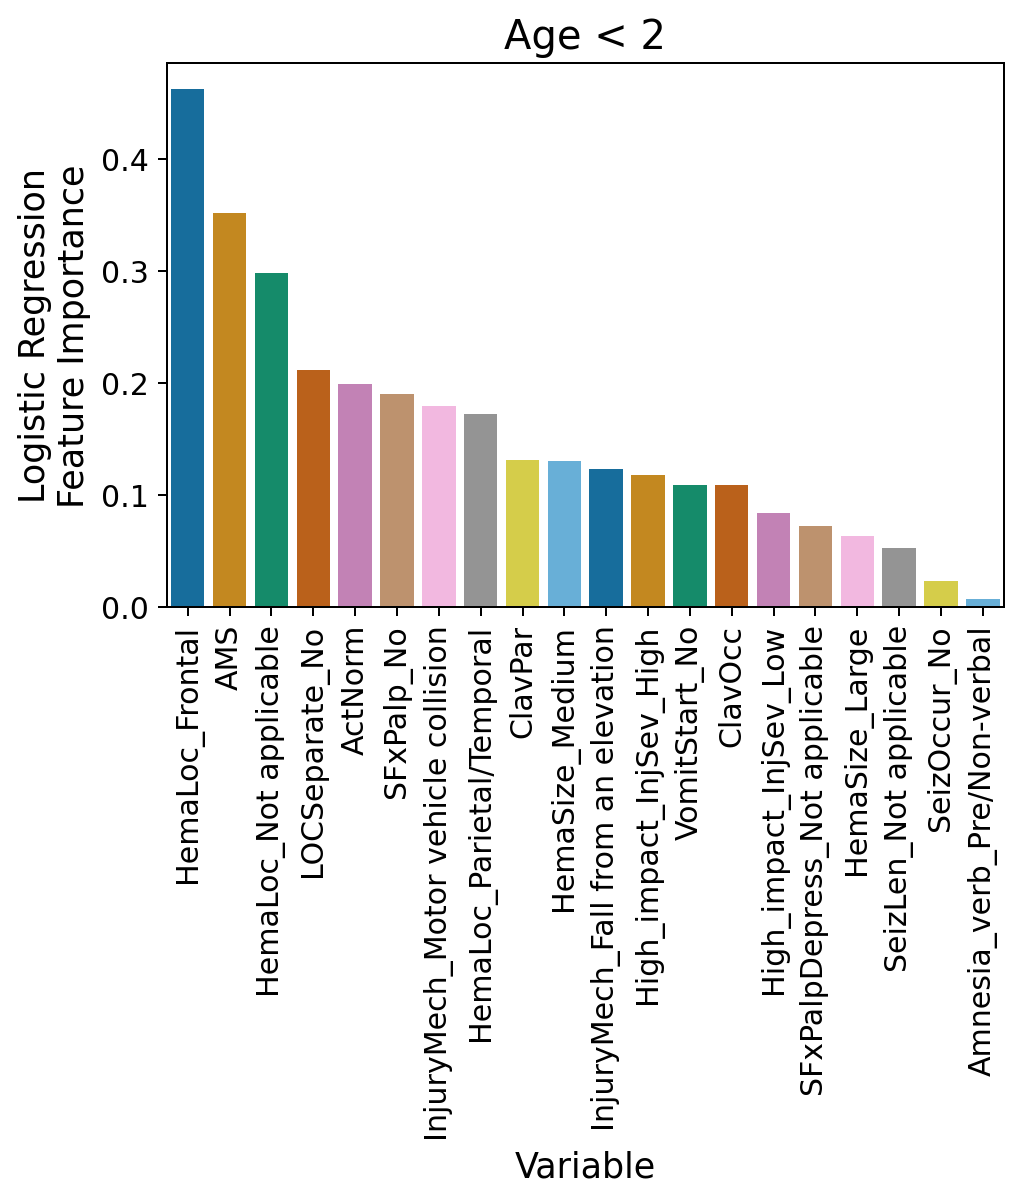

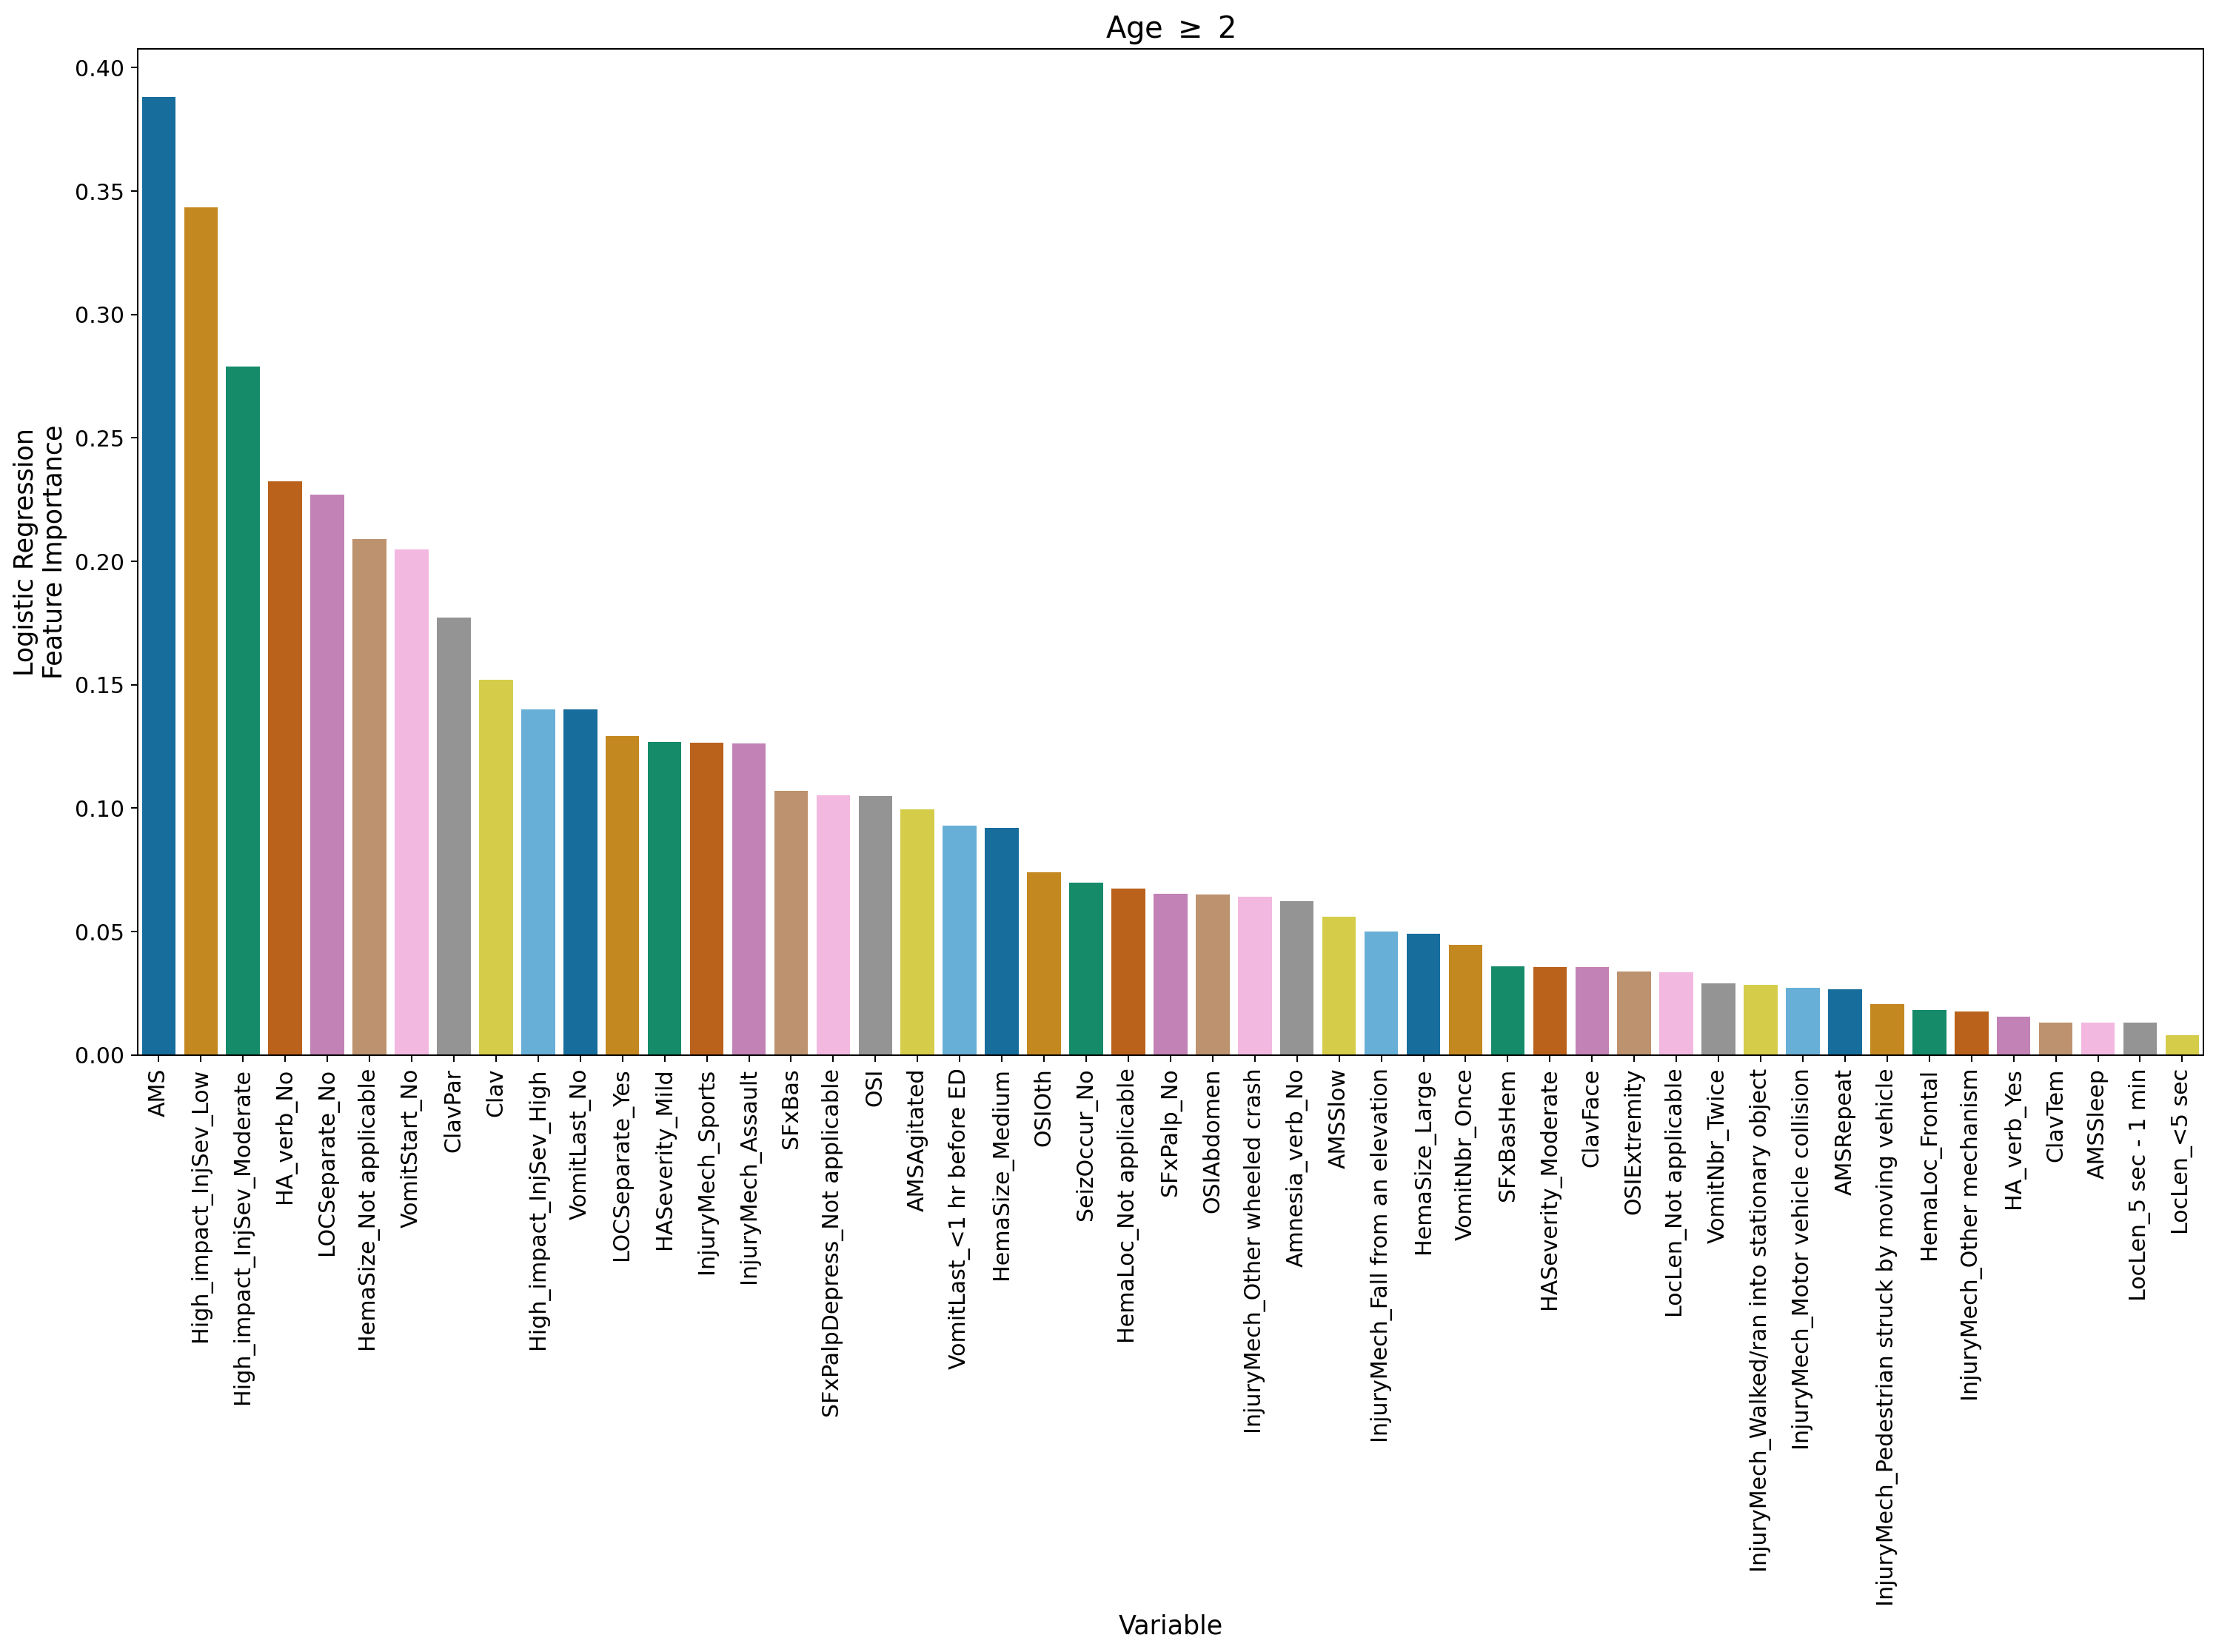

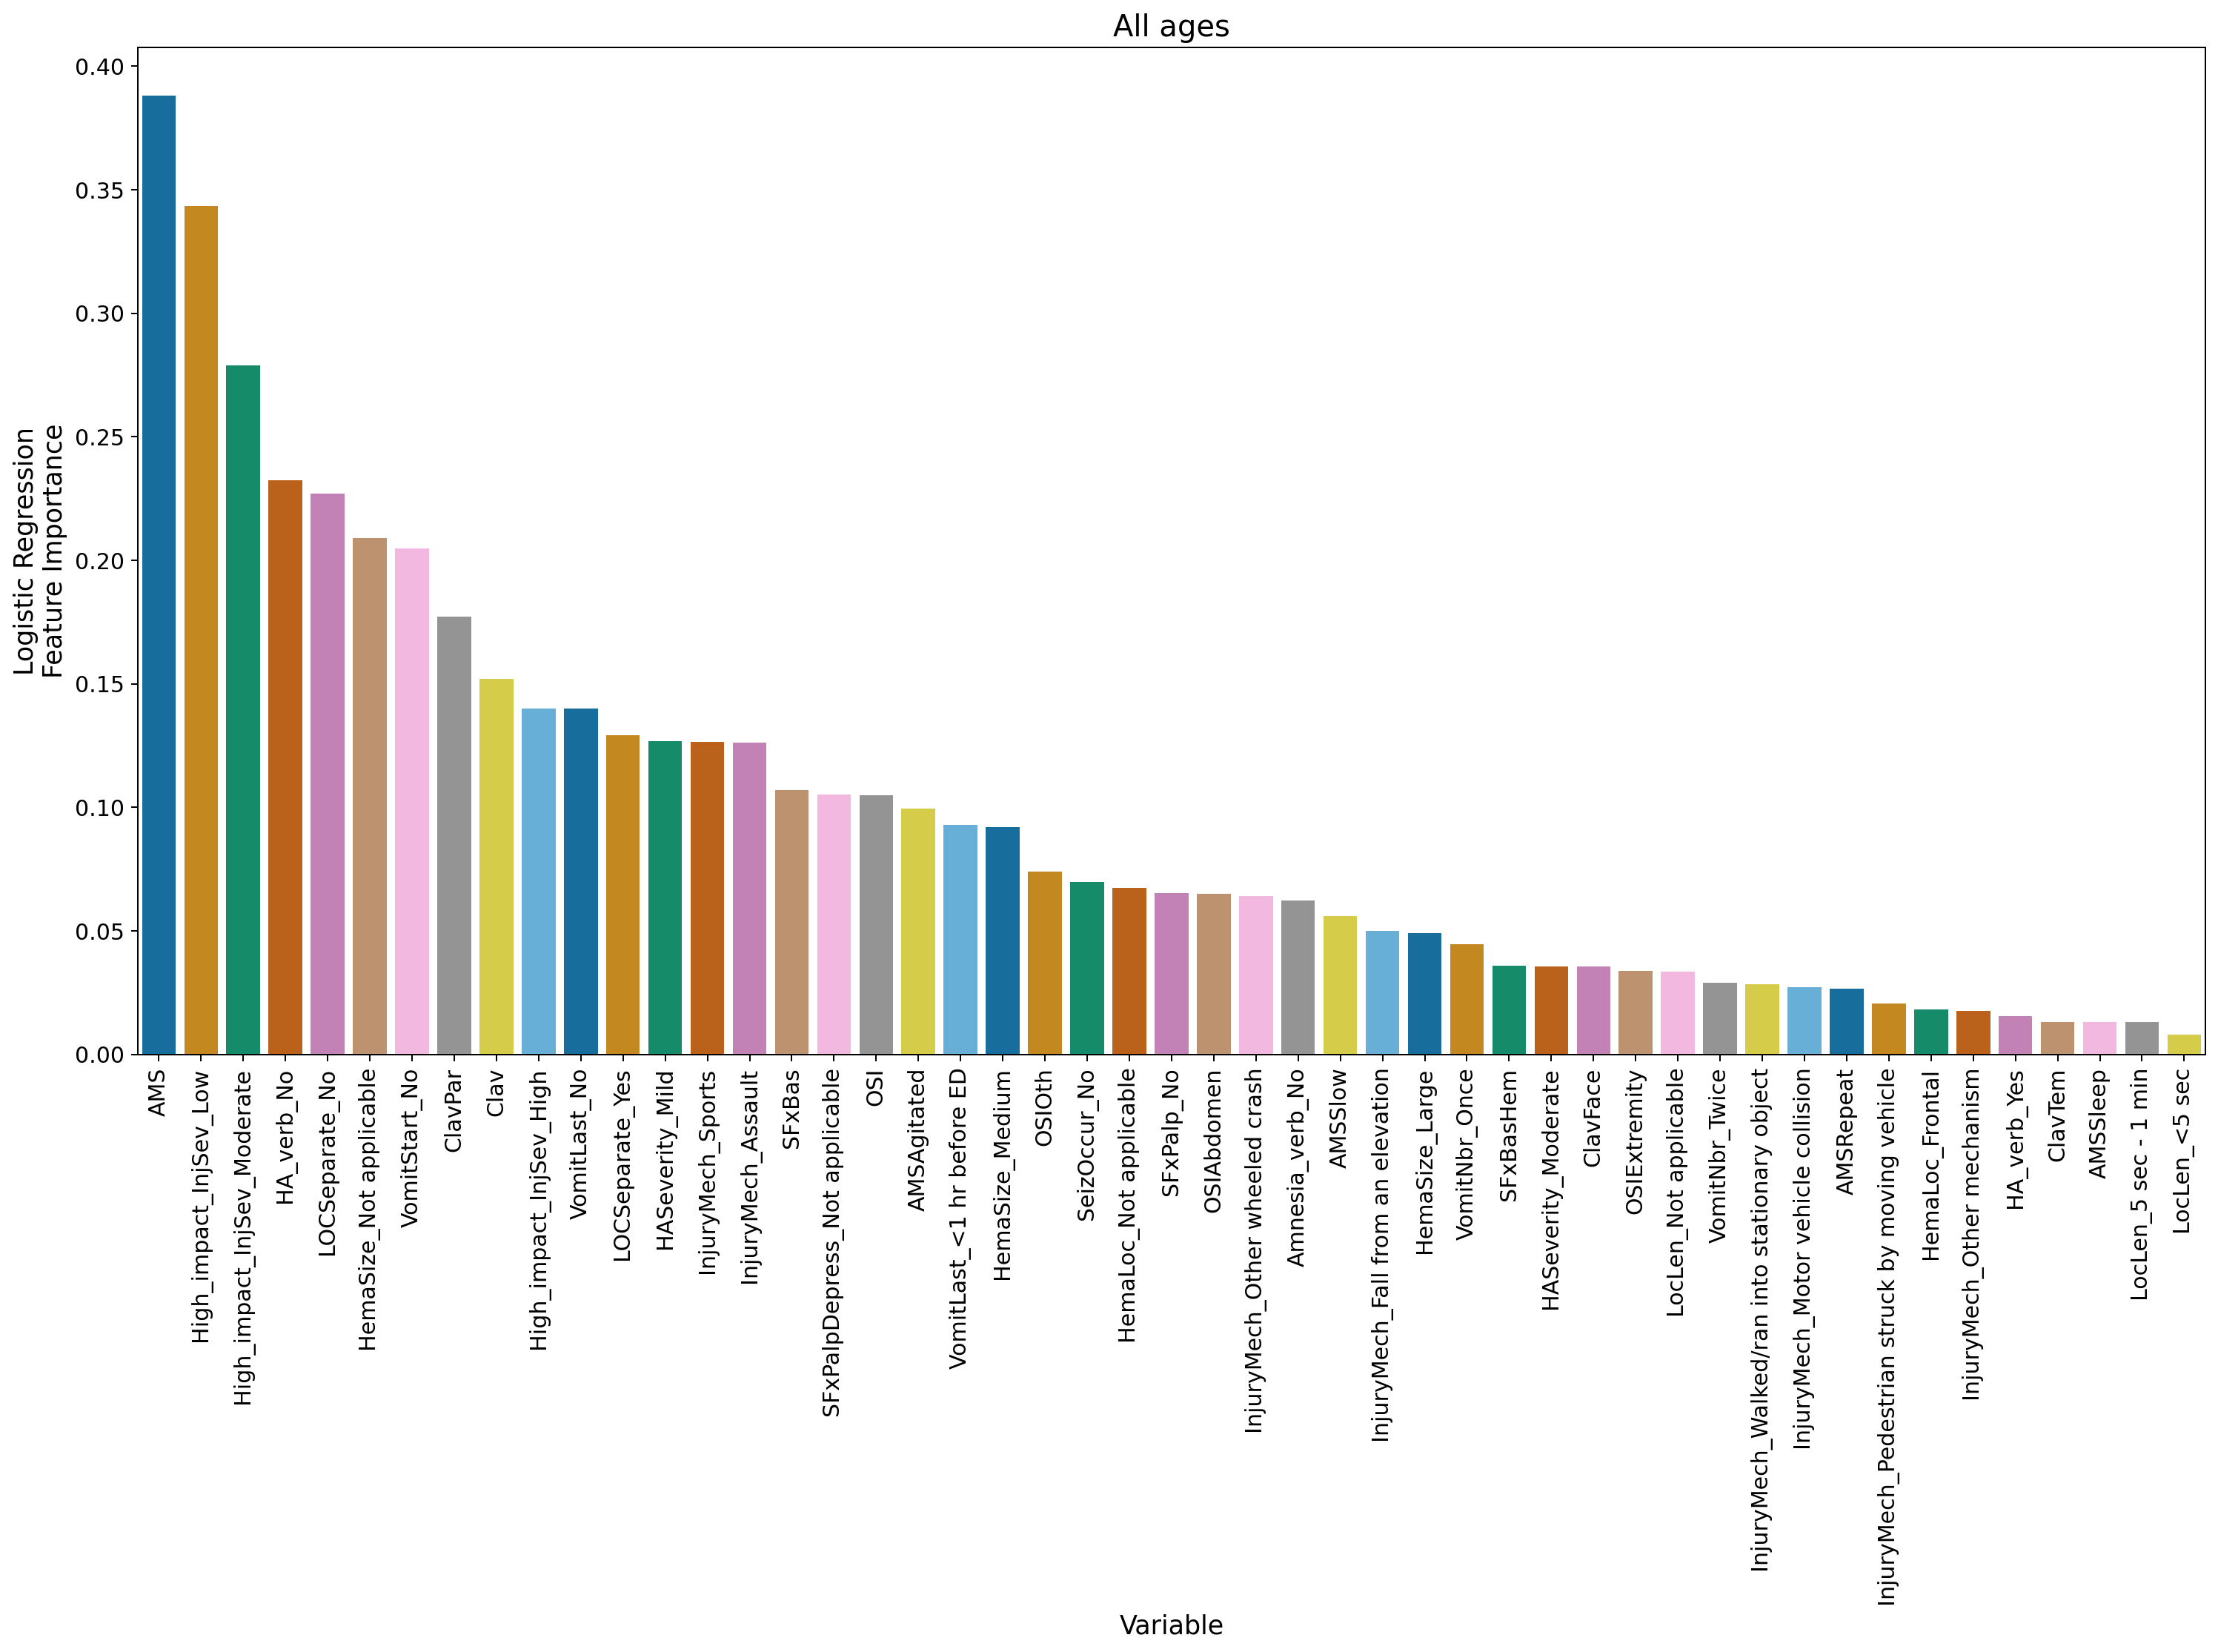

In [16]:
lr_young_feature_imp = np.abs(lr_model_young.coef_.flatten() * X_tune_young.std(axis=0))
lr_old_feature_imp = np.abs(lr_model_old.coef_.flatten() * X_tune_old.std(axis=0))
lr_all_feature_imp = np.abs(lr_model_all.coef_.flatten() * X_tune_all.std(axis=0))

lr_young_feature_imp = lr_young_feature_imp[np.argsort(lr_young_feature_imp)[::-1]]
lr_old_feature_imp = lr_old_feature_imp[np.argsort(lr_old_feature_imp)[::-1]]
lr_all_feature_imp = lr_all_feature_imp[np.argsort(lr_all_feature_imp)[::-1]]

lr_young_feature_imp = lr_young_feature_imp[lr_young_feature_imp > 0].to_frame().reset_index()
lr_old_feature_imp = lr_old_feature_imp[lr_old_feature_imp > 0].to_frame().reset_index()
lr_all_feature_imp = lr_all_feature_imp[lr_all_feature_imp > 0].to_frame().reset_index()

plt.figure()
sns.barplot(data=lr_young_feature_imp, x="index", y=0, palette="colorblind")
plt.xticks(rotation=90)
plt.xlabel("Variable")
plt.ylabel("Logistic Regression\nFeature Importance")
plt.title("Age < 2")
plt.savefig("./figs/lr_feat_importance_young.png", bbox_inches="tight")

plt.figure(figsize=(20, 10))
sns.barplot(data=lr_old_feature_imp, x="index", y=0, palette="colorblind")
plt.xticks(rotation=90, )
plt.xlabel("Variable")
plt.ylabel("Logistic Regression\nFeature Importance")
plt.title("Age " + r"$\geq$" + " 2")
plt.savefig("./figs/lr_feat_importance_old.png", bbox_inches="tight")

plt.figure(figsize=(20, 10))
sns.barplot(data=lr_old_feature_imp, x="index", y=0, palette="colorblind")
plt.xticks(rotation=90, )
plt.xlabel("Variable")
plt.ylabel("Logistic Regression\nFeature Importance")
plt.title("All ages")
plt.savefig("./figs/lr_feat_importance_all.png", bbox_inches="tight")



## Evaluate best model (LR) on test set

In [17]:
y_pred_young = lr_model_young.predict_proba(X_test_young)[:, 1] > lr_stats_young["threshold"]
y_pred_old = lr_model_old.predict_proba(X_test_old)[:, 1] > lr_stats_old["threshold"]
y_pred_all = lr_model_all.predict_proba(X_test_all)[:, 1] > lr_stats_old["threshold"]

test_stats = []
for y_test, y_pred in zip([y_test_young, y_test_old, y_test_all], [y_pred_young, y_pred_old, y_pred_all]):
    cm = confusion_matrix(y_test, y_pred, labels=[1, 0])
    
    # Calculating statistics
    n = sum(sum(cm))
    auc = roc_auc_score(y_test, y_pred)
    acc = (cm[0,0] + cm[1,1]) / n
    sens = cm[0,0] / (cm[0,0] + cm[0,1])
    spec = cm[1,1] / (cm[1,0] + cm[1,1])
    npv = cm[1, 1] / (cm[1, 1] + cm[0, 1])
    balacc = (sens + spec) / 2
    
    test_stats.append({'AUC' : auc, 'Accuracy' : acc, 'Balanced Accuracy' : balacc, 
                "Sensitivity" : sens, "Specificity" : spec, "NPV" : npv})

print(test_stats[0])
print("\n")
print(test_stats[1])
print("\n")
print(test_stats[2])

{'AUC': 0.8463898065125061, 'Accuracy': 0.7715617715617715, 'Balanced Accuracy': 0.846389806512506, 'Sensitivity': 0.9230769230769231, 'Specificity': 0.7697026899480888, 'NPV': 0.9987752602571953}


{'AUC': 0.848410044062218, 'Accuracy': 0.7620624408703879, 'Balanced Accuracy': 0.848410044062218, 'Sensitivity': 0.9365079365079365, 'Specificity': 0.7603121516164995, 'NPV': 0.9991628296358309}


{'AUC': 0.8215701400427249, 'Accuracy': 0.7935423049728966, 'Balanced Accuracy': 0.8215701400427249, 'Sensitivity': 0.85, 'Specificity': 0.7931402800854498, 'NPV': 0.9986551105797967}


In [37]:
test_stats_df = pd.DataFrame(columns=["Algorithm", "Age",
                                 "AUC", "Accuracy", "Sensitivity", "Specificity",
                                 "NPV", "Balanced Accuracy"
                                ])
alg_list = ["LR", "Baseline"]
age_list = ["young", "old", "all"] * len(alg_list)
alg_list = [val for val in alg_list for _ in range(3)]
for idx, st in enumerate([test_stats[0],
    test_stats[1],
    test_stats[2],
    baseline_stats_test[0], baseline_stats_test[1], baseline_stats_test[2]]):
    tmp_dict = {ky : st[ky] for ky in stats_df.columns if ky in st}
    tmp_dict["Algorithm"] = alg_list[idx]
    tmp_dict["Age"] = age_list[idx]
    
    test_stats_df = test_stats_df.append(tmp_dict, ignore_index=True)
np.round(test_stats_df, decimals=3).to_csv("./figs/model_test_results.csv", index=False)
test_stats_df



Algorithm    Age       AUC  Accuracy  Sensitivity  Specificity       NPV  \
0        LR  young  0.846390  0.771562     0.923077     0.769703  0.998775   
1        LR    old  0.848410  0.762062     0.936508     0.760312  0.999163   
2        LR    all  0.821570  0.793542     0.850000     0.793140  0.998655   
3  Baseline  young  0.774422  0.554312     1.000000     0.548844  1.000000   
4  Baseline    old  0.786059  0.638600     0.936508     0.635611  0.998999   
5  Baseline    all  0.777075  0.623026     0.933333     0.620817  0.999236   

   Balanced Accuracy  
0           0.846390  
1           0.848410  
2           0.821570  
3           0.774422  
4           0.786059  
5           0.777075

## Plots for best model (LR)

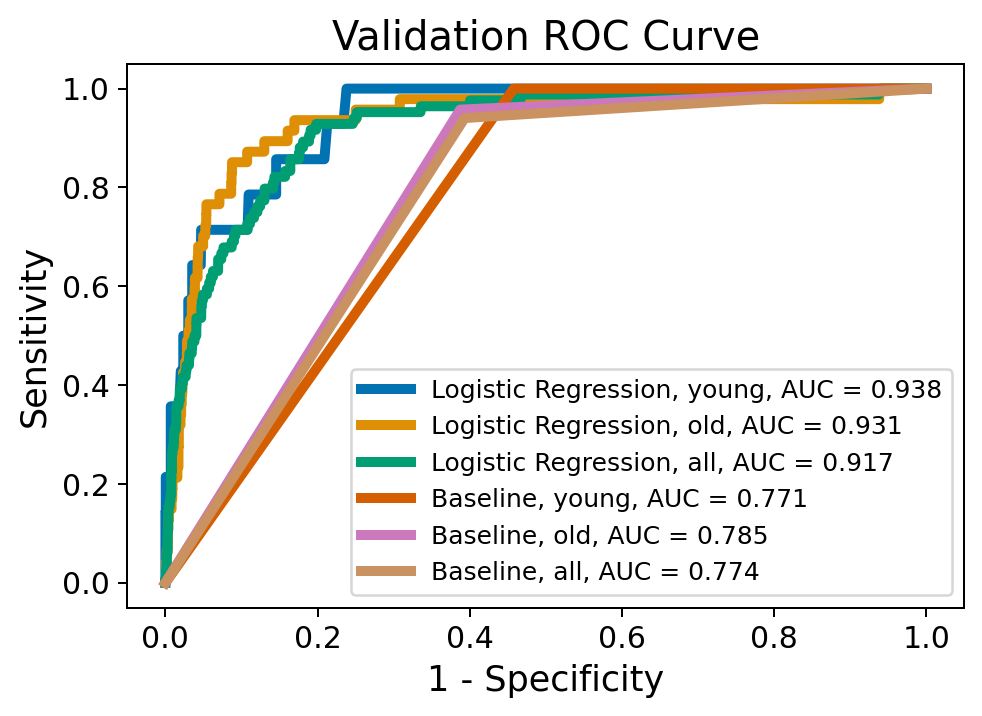

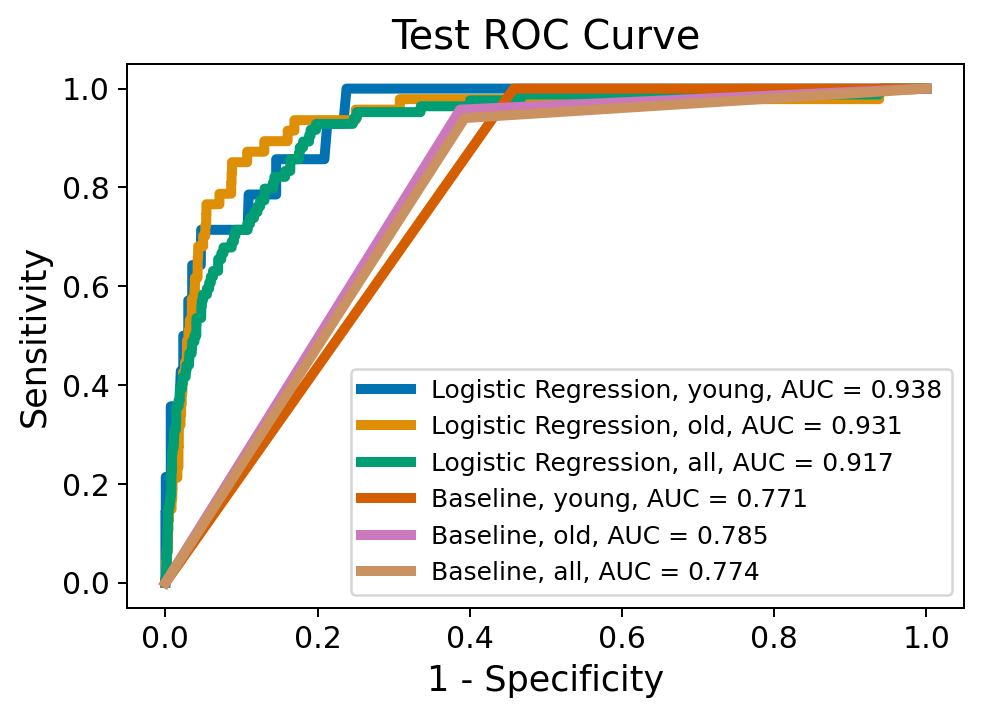

In [18]:
def plot_roc(model_young, model_old, model_all, model_baseline, data_young, data_old, data_all,
             model_str = "Logistic Regression", title_str="Validation ROC Curve", filename=None):
    X_young = data_young[0].copy()
    X_old = data_old[0].copy()
    X_all = data_all[0].copy()
    
    prob_young = model_young.predict_proba(X_young)[:, 1]
    prob_old = model_old.predict_proba(X_old)[:, 1]
    prob_all = model_all.predict_proba(X_all)[:, 1]
    
    X_young = add_binary_variables(X_young)
    X_old = add_binary_variables(X_old)
    X_all = add_binary_variables(X_all)
    X_young["AgeTwoPlus"] = 1
    X_old["AgeTwoPlus"] = 2
    
    prob_young_baseline = model_baseline(X_young)
    prob_old_baseline = model_baseline(X_old)
    prob_all_baseline = model_baseline(X_all)
    
    label_list = [model_str + ", young", model_str + ", old", model_str + ", all", 
                  "Baseline, young", "Baseline, old", "Baseline, all"]
    prob_list = [prob_young, prob_old, prob_all, prob_young_baseline, prob_old_baseline, prob_all_baseline]
    y_list = [data_young[1], data_old[1], data_all[1]] * 2
    plt.figure()
    for idx in range(len(label_list)):
        fpr, tpr, _ = roc_curve(y_list[idx], prob_list[idx])
        auc = roc_auc_score(y_list[idx], prob_list[idx])
        plt.plot(fpr, tpr, label=label_list[idx] + ", AUC = " + str(np.round(auc, decimals=3)), color=color_list[idx])
    plt.xlabel("1 - Specificity")
    plt.ylabel("Sensitivity")
    plt.title(title_str)
    plt.legend()
    plt.savefig("./figs/" + filename, bbox_inches="tight")

model_str = "Logistic Regression"

title_str = "Validation ROC Curve"
filename = "lr_val_roc.png" 
plot_roc(lr_model_young, lr_model_old, lr_model_all, baseline_pred, 
         (X_tune_young, y_tune_young), (X_tune_old, y_tune_old), (X_tune_all, y_tune_all),
         model_str, title_str, filename)
title_str = "Test ROC Curve"
filename = "lr_test_roc.png" 
plot_roc(lr_model_young, lr_model_old, lr_model_all, baseline_pred, 
         (X_tune_young, y_tune_young), (X_tune_old, y_tune_old), (X_tune_all, y_tune_all),
         model_str, title_str, filename)






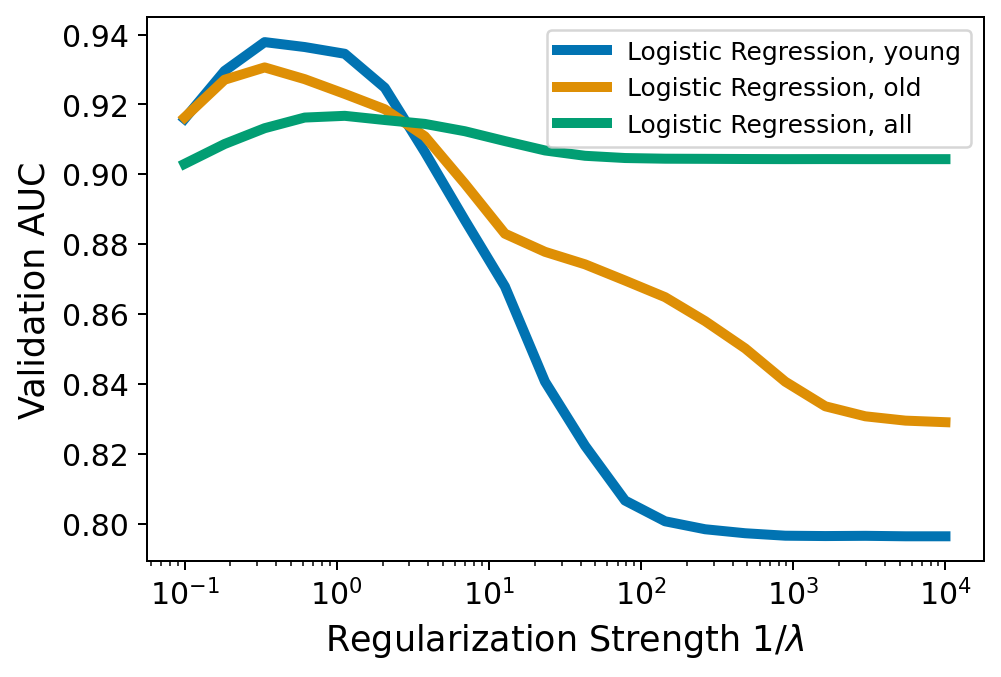

In [19]:
young_auc_list = []
old_auc_list = []
all_auc_list = []
for l_idx, l_val in enumerate(lambda_list):
    logreg_model = LogisticRegression(solver='liblinear', 
                                      penalty="l1", 
                                      random_state = 0, 
                                      C = l_val).fit(X_train_young, y_train_young)
    young_auc_list.append(roc_auc_score(y_tune_young, logreg_model.predict_proba(X_tune_young)[:, 1]))
    
    logreg_model = LogisticRegression(solver='liblinear', 
                                      penalty="l1", 
                                      random_state = 0, 
                                      C = l_val).fit(X_train_old, y_train_old)
    old_auc_list.append(roc_auc_score(y_tune_old, logreg_model.predict_proba(X_tune_old)[:, 1]))
    
    logreg_model = LogisticRegression(solver='liblinear', 
                                      penalty="l1", 
                                      random_state = 0, 
                                      C = l_val).fit(X_train_all, y_train_all)
    all_auc_list.append(roc_auc_score(y_tune_all, logreg_model.predict_proba(X_tune_all)[:, 1]))

plt.figure()
plt.plot(lambda_list, young_auc_list, label="Logistic Regression, young", color=color_list[0])
plt.plot(lambda_list, old_auc_list, label="Logistic Regression, old", color=color_list[1])
plt.plot(lambda_list, all_auc_list, label="Logistic Regression, all", color=color_list[2])
plt.xscale("log")
plt.xlabel("Regularization Strength " + r"$1/\lambda$")
plt.ylabel("Validation AUC")
plt.legend()
plt.savefig("./figs/" + "lr_auc_lambda.png", bbox_inches="tight")

# Stability analysis: verbal v. not

Make sure to edit/reedit datasets.py to include/not AgeinYears

In [20]:
df_train, df_tune, df_test = Dataset().get_data(simple = False, young = True, old = True)



kwargs {'clean_data': {}, 'preprocess_data': {'infer_outcome': True, 'drop_low_gcs': True, 'impute_unknowns': 'mode', 'impute_not_applicables': True}, 'extract_features': {}}


In [21]:
nvb_idx = (df_train["HA_verb_Pre/Non-verbal"] == 1)# & (df_train["AgeinYears"] < 5) 
vb_idx = np.logical_not(nvb_idx)

X_nvb_train = df_train.loc[nvb_idx].drop(columns=["outcome"])
y_nvb_train = df_train.loc[nvb_idx]["outcome"].values
X_vb_train = df_train.loc[vb_idx].drop(columns=["outcome"])
y_vb_train = df_train.loc[vb_idx]["outcome"].values

nvb_idx = (df_tune["HA_verb_Pre/Non-verbal"] == 1) #& (df_tune["AgeinYears"] < 5) 
vb_idx = np.logical_not(nvb_idx)

X_nvb_tune = df_tune.loc[nvb_idx].drop(columns=["outcome"])
y_nvb_tune = df_tune.loc[nvb_idx]["outcome"].values
X_vb_tune = df_tune.loc[vb_idx].drop(columns=["outcome"])
y_vb_tune = df_tune.loc[vb_idx]["outcome"].values

nvb_idx = (df_test["HA_verb_Pre/Non-verbal"] == 1) #& (df_test["AgeinYears"] < 5) 
vb_idx = np.logical_not(nvb_idx)

X_nvb_test = df_test.loc[nvb_idx].drop(columns=["outcome"])
y_nvb_test = df_test.loc[nvb_idx]["outcome"].values
X_vb_test = df_test.loc[vb_idx].drop(columns=["outcome"])
y_vb_test = df_test.loc[vb_idx]["outcome"].values

100%|██████████████████████████████████████| 1206/1206 [00:07<00:00, 165.02it/s]


Confusion Matrix : 
 [[  21    1]
 [ 732 1975]]
Prob. threshold : 0.00462
AUC             : 0.896
Accuracy        : 0.731
Sensitivity     : 0.955
Specificity     : 0.730
Balanced Acc.   : 0.842
NPV             : 0.999


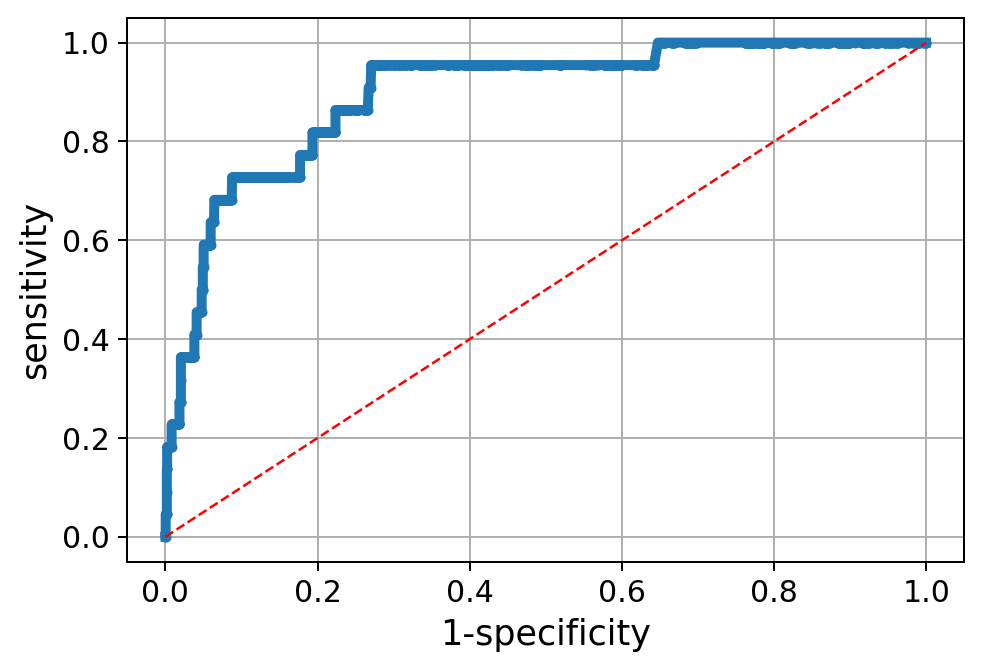

100%|███████████████████████████████████████| 3685/3685 [00:45<00:00, 80.78it/s]


Confusion Matrix : 
 [[  59    3]
 [1239 4456]]
Prob. threshold : 0.00515
AUC             : 0.925
Accuracy        : 0.784
Sensitivity     : 0.952
Specificity     : 0.782
Balanced Acc.   : 0.867
NPV             : 0.999


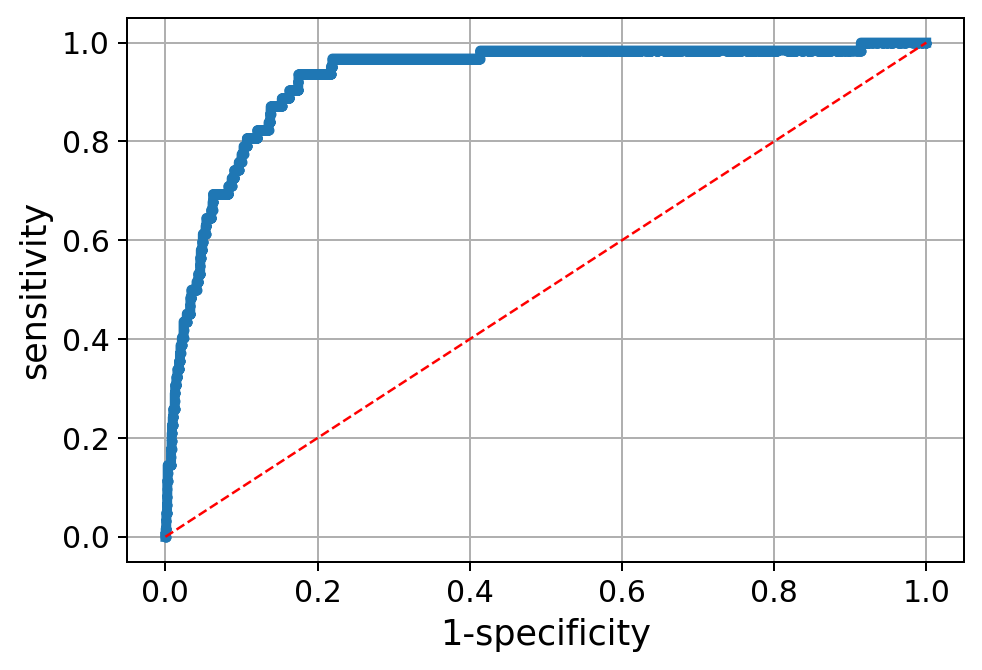

In [22]:
model_nvb, nvb_stats = fit_eval_lr(X_nvb_train, y_nvb_train, X_nvb_tune, y_nvb_tune, "", lamb_vec = lambda_list)
model_vb, vb_stats = fit_eval_lr(X_vb_train, y_vb_train, X_vb_tune, y_vb_tune, "", lamb_vec = lambda_list)

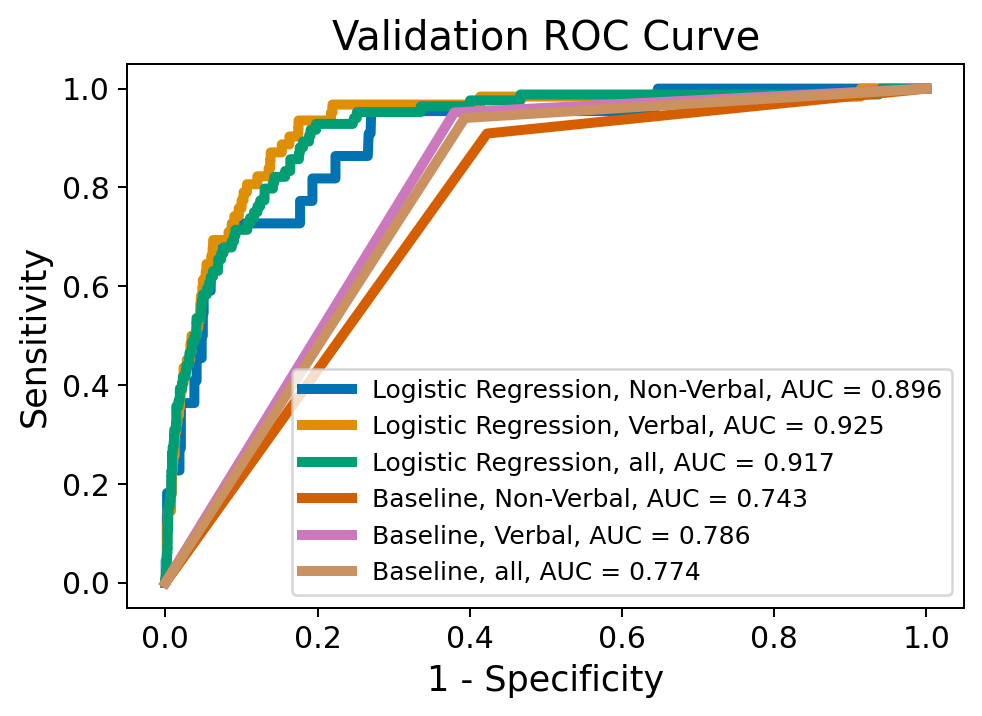

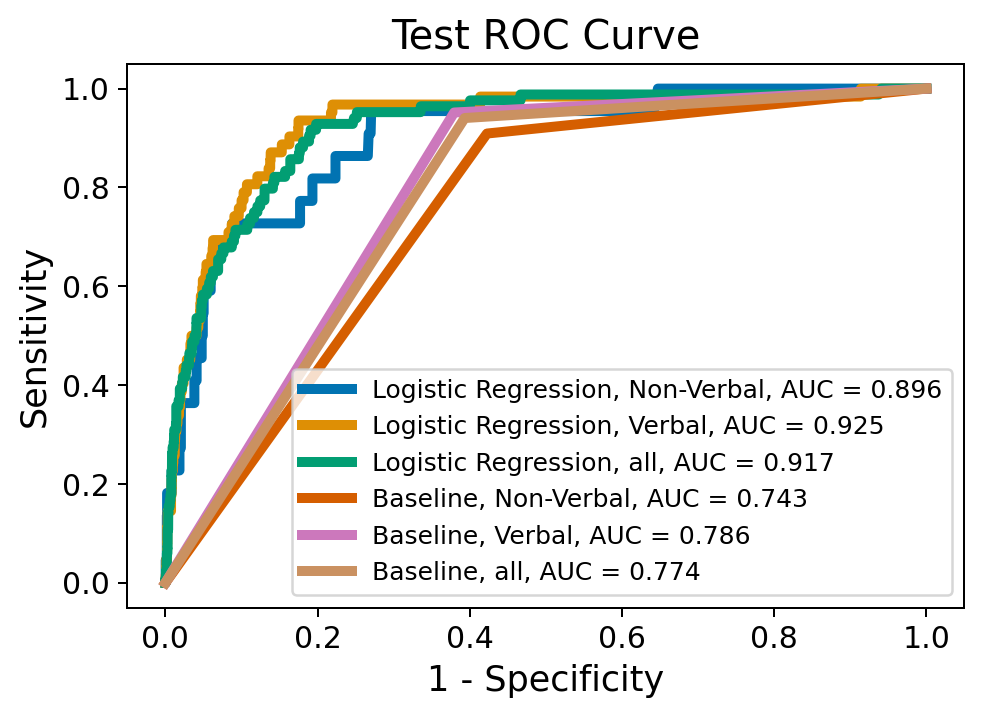

In [23]:
def plot_roc(model_nvb, model_vb, model_all, model_baseline, data_nvb, data_vb, data_all,
             model_str = "Logistic Regression", title_str="Validation ROC Curve", filename=None):
    X_young = data_nvb[0].copy()
    X_old = data_vb[0].copy()
    X_all = data_all[0].copy()
    
    prob_young = model_nvb.predict_proba(X_young)[:, 1]
    prob_old = model_vb.predict_proba(X_old)[:, 1]
    prob_all = model_all.predict_proba(X_all)[:, 1]
    
    X_young = add_binary_variables(X_young)
    X_old = add_binary_variables(X_old)
    X_all = add_binary_variables(X_all)
    
    prob_young_baseline = model_baseline(X_young)
    prob_old_baseline = model_baseline(X_old)
    prob_all_baseline = model_baseline(X_all)
    
    label_list = [model_str + ", Non-Verbal", model_str + ", Verbal", model_str + ", all", 
                  "Baseline, Non-Verbal", "Baseline, Verbal", "Baseline, all"]
    prob_list = [prob_young, prob_old, prob_all, prob_young_baseline, prob_old_baseline, prob_all_baseline]
    y_list = [data_nvb[1], data_vb[1], data_all[1]] * 2
    plt.figure()
    for idx in range(len(label_list)):
        fpr, tpr, _ = roc_curve(y_list[idx], prob_list[idx])
        auc = roc_auc_score(y_list[idx], prob_list[idx])
        plt.plot(fpr, tpr, label=label_list[idx] + ", AUC = " + str(np.round(auc, decimals=3)), color=color_list[idx])
    plt.xlabel("1 - Specificity")
    plt.ylabel("Sensitivity")
    plt.title(title_str)
    plt.legend()
    plt.savefig("./figs/" + filename, bbox_inches="tight")

model_str = "Logistic Regression"

title_str = "Validation ROC Curve"
filename = "lr_val_roc_verbal.png" 
plot_roc(model_nvb, model_vb, lr_model_all, baseline_pred, 
         (X_nvb_tune, y_nvb_tune), (X_vb_tune, y_vb_tune), (X_tune_all, y_tune_all),
         model_str, title_str, filename)
title_str = "Test ROC Curve"
filename = "lr_test_roc_verbal.png" 
plot_roc(model_nvb, model_vb, lr_model_all, baseline_pred, 
         (X_nvb_tune, y_nvb_tune), (X_vb_tune, y_vb_tune), (X_tune_all, y_tune_all),
         model_str, title_str, filename)






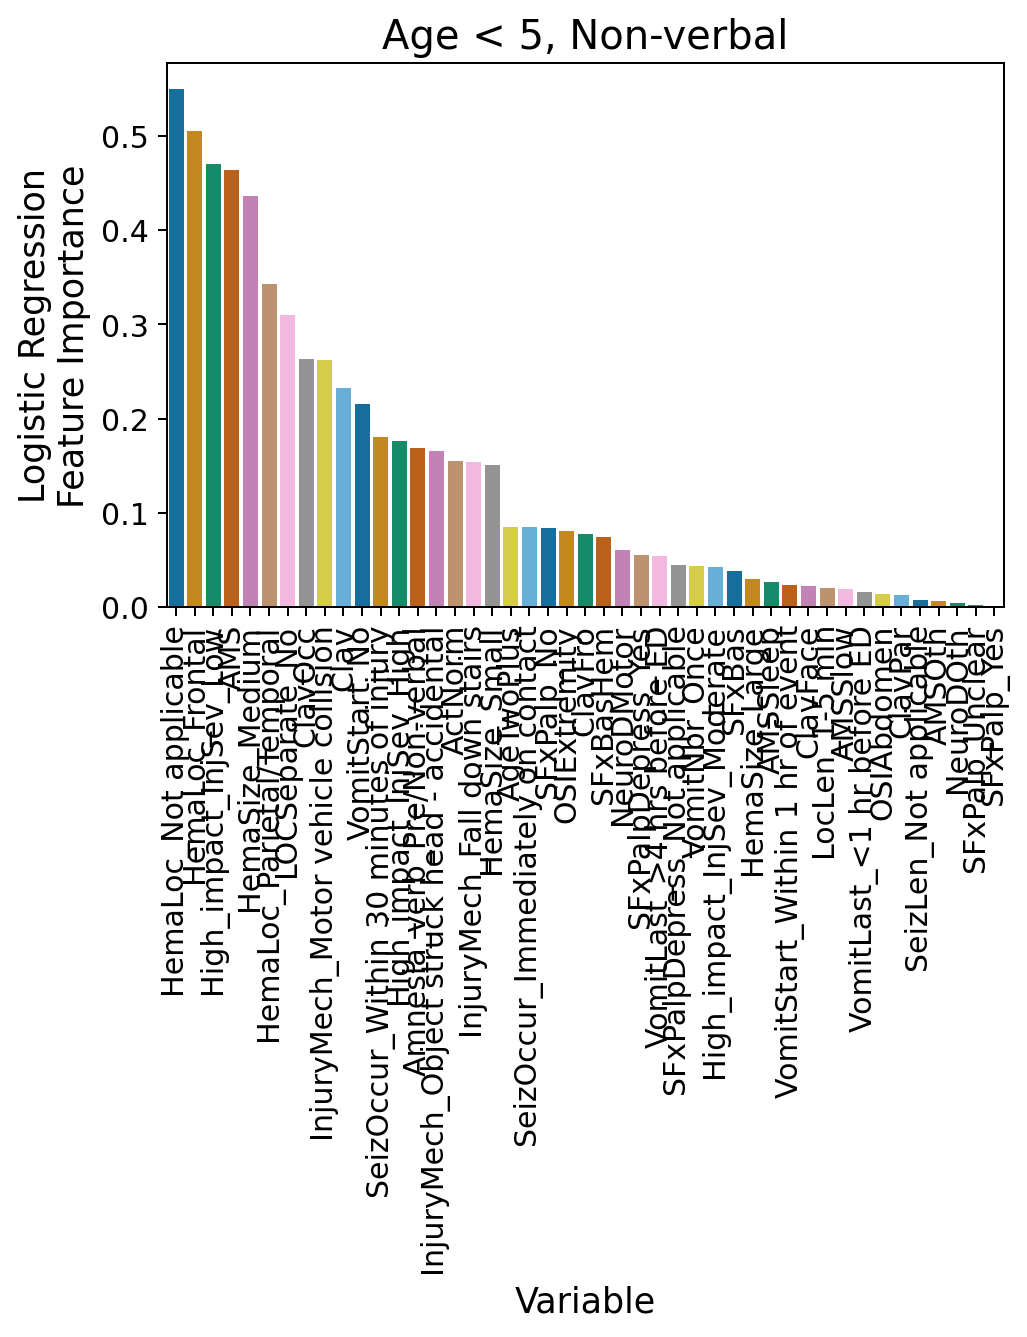

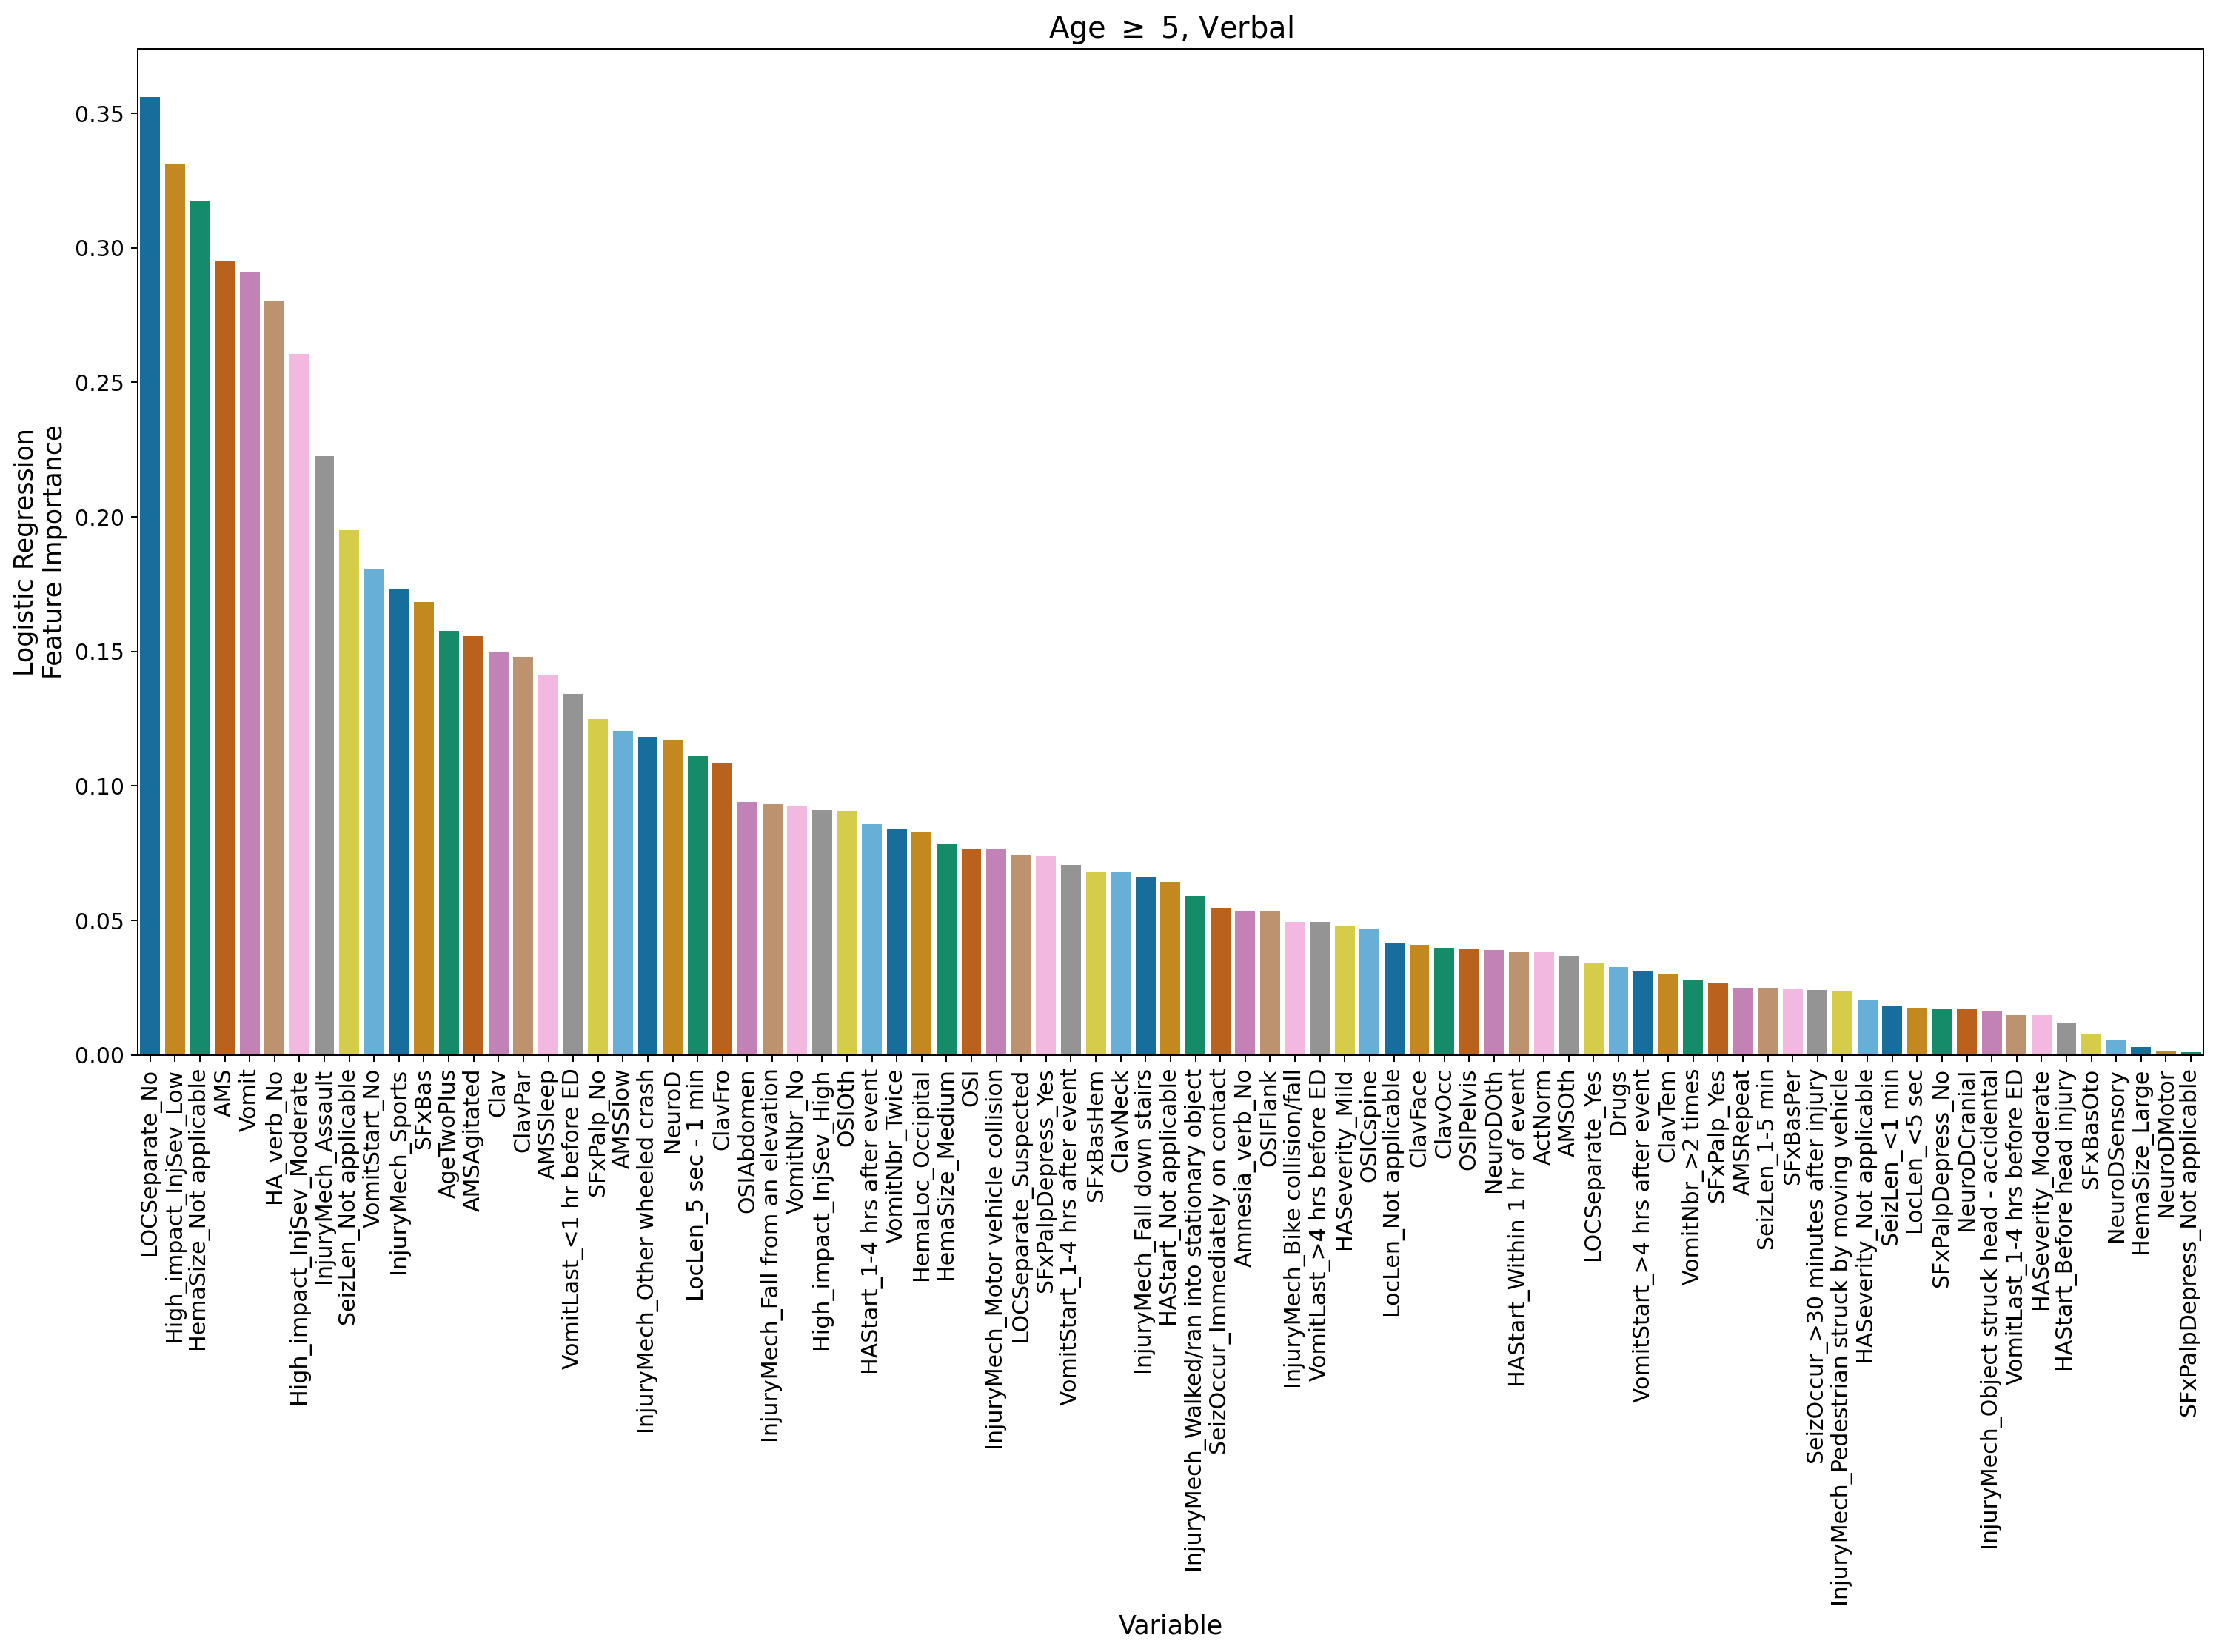

In [24]:
lr_young_feature_imp = np.abs(model_nvb.coef_.flatten() * X_nvb_tune.std(axis=0))
lr_old_feature_imp = np.abs(model_vb.coef_.flatten() * X_vb_tune.std(axis=0))

lr_young_feature_imp = lr_young_feature_imp[np.argsort(lr_young_feature_imp)[::-1]]
lr_old_feature_imp = lr_old_feature_imp[np.argsort(lr_old_feature_imp)[::-1]]

lr_young_feature_imp = lr_young_feature_imp[lr_young_feature_imp > 0].to_frame().reset_index()
lr_old_feature_imp = lr_old_feature_imp[lr_old_feature_imp > 0].to_frame().reset_index()

plt.figure()
sns.barplot(data=lr_young_feature_imp, x="index", y=0, palette="colorblind")
plt.xticks(rotation=90)
plt.xlabel("Variable")
plt.ylabel("Logistic Regression\nFeature Importance")
plt.title("Age < 5, Non-verbal")
plt.savefig("./figs/lr_feat_importance_nonverbal.png", bbox_inches="tight")

plt.figure(figsize=(20, 10))
sns.barplot(data=lr_old_feature_imp, x="index", y=0, palette="colorblind")
plt.xticks(rotation=90, )
plt.xlabel("Variable")
plt.ylabel("Logistic Regression\nFeature Importance")
plt.title("Age " + r"$\geq$" + " 5, Verbal")
plt.savefig("./figs/lr_feat_importance_verbal.png", bbox_inches="tight")



# Baseline Rosetta Stone

In [8]:
def add_var(data) :
    df = data.copy()

    df['HemaBinary'] = np.maximum.reduce([df['HemaLoc_Occipital'], df['HemaLoc_Parietal/Temporal']])
    df['LocBinary'] = np.maximum.reduce([df['LocLen_5 sec - 1 min'], df['LocLen_1-5 min'], df['LocLen_>5 min']])
    df['MechBinary'] = df['High_impact_InjSev_High']
    df['HABinary'] = df['HASeverity_Severe']
    df['SeizLen'] = np.maximum.reduce([df['SeizLen_1-5 min'], df['SeizLen_5-15 min'], df['SeizLen_>15 min']])
    df['HemaSizeBinary'] = np.maximum.reduce([df['HemaSize_Large'], df['HemaSize_Medium']])
    df['LocSeparateBinary'] = np.maximum.reduce([df['LOCSeparate_Suspected'], df['LOCSeparate_Yes']])
    df['SFxPalpBinary'] = np.maximum.reduce([df['SFxPalp_Unclear'], df['SFxPalp_Yes']])

    return df

In [9]:
df_tune_young = X_tune_young.copy()
df_tune_young['outcome'] = y_tune_young

df_tune_old = X_tune_old.copy()
df_tune_old['outcome'] = y_tune_old

100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 84.39it/s]


Confusion Matrix : 
 [[  14    0]
 [ 592 1538]]
Prob. threshold : 0.00460
AUC             : 0.903
Accuracy        : 0.724
Sensitivity     : 1.000
Specificity     : 0.722
Balanced Acc.   : 0.861
NPV             : 1.000


{'AUC': 0.9025486250838364,
 'Accuracy': 0.7238805970149254,
 'Balanced Accuracy': 0.8610328638497653,
 'Sensitivity': 1.0,
 'Specificity': 0.7220657276995305,
 'NPV': 1.0,
 'threshold': 0.0046}

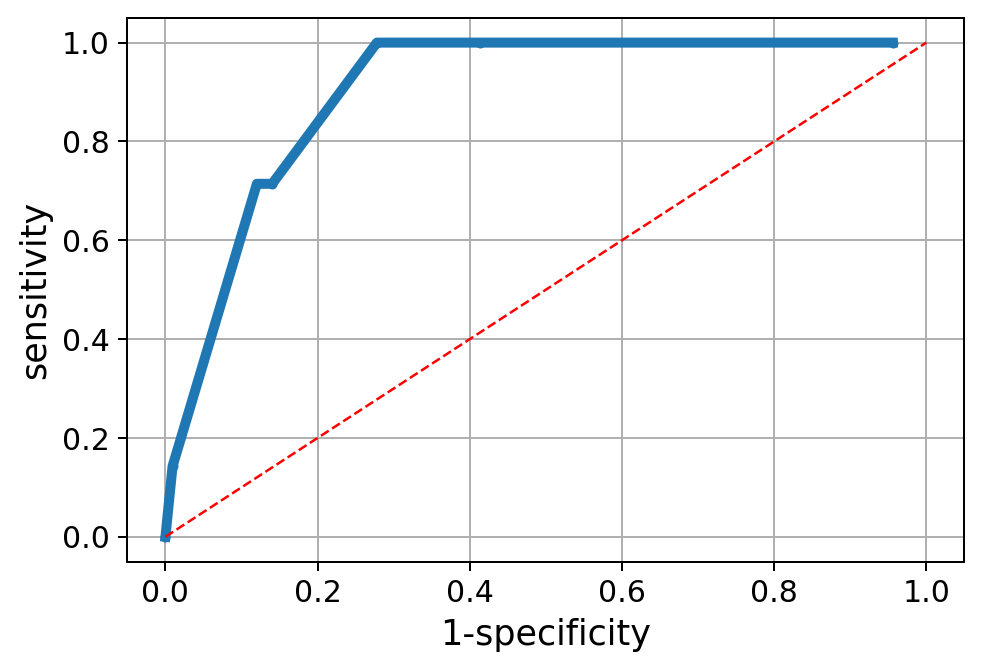

In [10]:
# IF WE NEED ACTUAL PROBABILITY
prob_base_young = Baseline('young').predict_proba(add_var(df_tune_young))

predict_stats(Baseline('young'), add_var(df_tune_young), y_tune_young)

100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 19.34it/s]


Confusion Matrix : 
 [[  45    2]
 [2438 3857]]
Prob. threshold : 0.00000
AUC             : 0.869
Accuracy        : 0.615
Sensitivity     : 0.957
Specificity     : 0.613
Balanced Acc.   : 0.785
NPV             : 0.999


{'AUC': 0.8686884220843967,
 'Accuracy': 0.6152633238725954,
 'Balanced Accuracy': 0.7850776536596082,
 'Sensitivity': 0.9574468085106383,
 'Specificity': 0.6127084988085783,
 'NPV': 0.9994817310183985,
 'threshold': 4.773920752915501e-06}

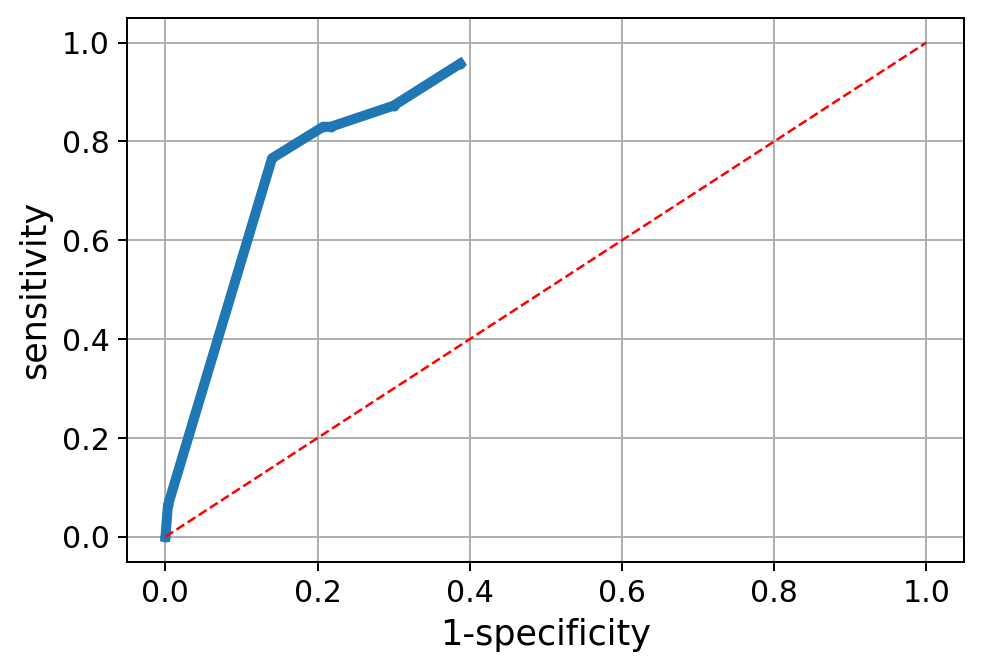

In [11]:
# IF WE NEED ACTUAL PROBABILITY
prob_base_old = Baseline('old').predict_proba(add_var(df_tune_old))

predict_stats(Baseline('old'), add_var(df_tune_old), y_tune_old)